In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

import twint
import nest_asyncio
nest_asyncio.apply()

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
tweets_data = pd.read_csv('../Cleaning/Clean_Dataset.csv')
tweets = tweets_data[['Clean_Text','Stop_Words_Text','Stemming_Text', 'New_Location', 'indonlp_sentiment', 'Lexicon_Score', 'Lexicon_Sentiment']]

In [3]:
tweets.head()

,Clean_Text,Stop_Words_Text,Stemming_Text,New_Location,indonlp_sentiment,Lexicon_Score,Lexicon_Sentiment
0,cina dan as terus bersaing mengembangkan tekno...,cina as bersaing mengembangkan teknologi terba...,cina as saing kembang teknologi baru usaha neg...,Jakarta,neutral,9,positive
1,katanya mau metaverse tapi down melulu bagaima...,katanya metaverse down melulu deh mas zuck,kata metaverse down melulu deh mas zuck,Indonesia,negative,-2,negative
2,mungkin facebook sudah berencana menjadi metav...,mungkin facebook berencana metaverse menyiapka...,mungkin facebook rencana metaverse siap diem s...,Indonesia,positive,24,positive
3,bersaing dengan perusahaan kelas dunia untuk m...,bersaing perusahaan kelas dunia mencapai sekto...,saing usaha kelas dunia capai sektor publik sw...,Indonesia,neutral,8,positive
4,staff dengan mah lulusan kampus terbaik lah ka...,staff mah lulusan kampus terbaik attitude krit...,staff mah lulus kampus baik attitude kritik bu...,NaN,negative,3,positive


In [4]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered 
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(text):
    sentence = ' '.join(word for word in text)
    return sentence

In [5]:
tweets['text_preprocessed'] = tweets['Stop_Words_Text'].apply(lambda x: tokenizingText(x))

In [6]:
tweets.head()

,Clean_Text,Stop_Words_Text,Stemming_Text,New_Location,indonlp_sentiment,Lexicon_Score,Lexicon_Sentiment,text_preprocessed
0,cina dan as terus bersaing mengembangkan tekno...,cina as bersaing mengembangkan teknologi terba...,cina as saing kembang teknologi baru usaha neg...,Jakarta,neutral,9,positive,"[cina, as, bersaing, mengembangkan, teknologi,..."
1,katanya mau metaverse tapi down melulu bagaima...,katanya metaverse down melulu deh mas zuck,kata metaverse down melulu deh mas zuck,Indonesia,negative,-2,negative,"[katanya, metaverse, down, melulu, deh, mas, z..."
2,mungkin facebook sudah berencana menjadi metav...,mungkin facebook berencana metaverse menyiapka...,mungkin facebook rencana metaverse siap diem s...,Indonesia,positive,24,positive,"[mungkin, facebook, berencana, metaverse, meny..."
3,bersaing dengan perusahaan kelas dunia untuk m...,bersaing perusahaan kelas dunia mencapai sekto...,saing usaha kelas dunia capai sektor publik sw...,Indonesia,neutral,8,positive,"[bersaing, perusahaan, kelas, dunia, mencapai,..."
4,staff dengan mah lulusan kampus terbaik lah ka...,staff mah lulusan kampus terbaik attitude krit...,staff mah lulus kampus baik attitude kritik bu...,NaN,negative,3,positive,"[staff, mah, lulusan, kampus, terbaik, attitud..."


### Analysis and Visualization

##### Comparison Sentiment Polarity on Tweets Data

##### Top 10 Positive and Negative Tweet Sentiments

In [7]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['indonlp_sentiment'] == 'positive']
positive_tweets = positive_tweets[['Clean_Text', 'Lexicon_Score','indonlp_sentiment']].sort_values(by = 'Lexicon_Score', ascending = False)[0:10].reset_index(drop=True)
positive_tweets.index += 1
positive_tweets[0:10]

,Clean_Text,Lexicon_Score,indonlp_sentiment
1,di masa depan pelaku bisnis mampu mengembangkan potensi mereka dan merambah sampai ke dunia untuk memberikan pengalaman baru kepada para pelanggan mereka ungkap berbagai potensi bisnis dalam dunia di webinar ids peluang bisnis masa depan,43,positive
2,tertawa ada gunanya juga aku ikut hunter disini walaupun belum pernah dapat uang tapi sudah dapat ilmu baru metaverse iya aku pertama kali tahu dari sini dan ide ini aku cobakan di esai ku semoga bisa selesai walaupun belum tahu benar tentang metaverse,39,positive
3,aduh mimin senang banget beli kpi ke dapat penghargaan best metaverse performance ready for love dan best ke pop song lalisa lisa dan lebih bahagia lagi lihat taylor menikmati penampilan beli kpi ke aduh jadi pengen mereka collab ngomong-ngomong mimin libur dulu iya unknown,39,positive
4,mohon maaf lahir batin selamat hari raya idul fitri selamat lebaran dan selamat liburan tidak punya baju baru di dunia nyata tahun ini tapi di metaverse aku pakai koleksi aku so far so bahagia monangys,38,positive
5,alhamdulillah akhirnya kesampaian pakai huhuhu seneng banget terimakasih banyak untuk kak dan kak sudah bantu kirimin saldo nya serta terimakasih juga untuk sponsor,36,positive
6,aku sudah nonton videonya sampai selesai pas melihat tweet kakak dan yah metaverse benar benar mencerminkan dunia kaya di sao cara dr indrawan ngejelasinnya juga benar benar mirip sama cara kerjanya dunia di sao,36,positive
7,mekanisme konsensus jaringan lebih secure tapi transaksi selesai lebih cepat kita bersyukur menemukan inovasi ini sehingga ke depan hidup di ruang metaverse menjadi lebih mudah cepat dan aman,36,positive
8,wkwkwk sudah ketebak dengan cuman manfaatin aespa buat project metaverse mereka lihat saja setiap ada konten ae kebanyakn pasti ada hubungannya sama metaverse semangat banget kalau ada hubungannya sama metaverse giliran konten yang sederhana saja peliiit banget,36,positive
9,merekam proses gambar di ig dan ada beberapa teman bertanya buat nft iya tidak semua gambar buat dijajakan di pasar metaverse sayang in fact tidak semua karya dibuat untuk dijual kadang memang pengen saja bikin bikin making art brings joy isn t that what art is all about,36,positive
10,munculnya sikap pengkhianatan untuk kebutuhan bertahan hidup di dunia usaha yang mungkin merasuk ke dalam hubungan keluarga satukan hati dan makin bertekun dalam tuhan kebenaran hati hati menguji suara keilahian dj manajement,35,positive


In [8]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = tweets[tweets['indonlp_sentiment'] == 'negative']
negative_tweets = negative_tweets[['Clean_Text', 'Lexicon_Score','indonlp_sentiment']].sort_values(by = 'Lexicon_Score', ascending = True)[0:10].reset_index(drop=True)
negative_tweets.index += 1
negative_tweets[0:10]

,Clean_Text,Lexicon_Score,indonlp_sentiment
1,"yang nft demam metaverse dirjen pajak cawe ngewe meki ber belatung musisi siapa yang kena narkotika, psikotropika, dan obat terlarang intoleran parno sajen ketangkep adaaa saja yang sliweran netijen yang dedicated eyel an dengan bahasa ndakik as always saya mah bodo amatan fokus saya bukan yang diatas asal saya notice saja dh cukup",-70,negative
2,kenapa karena banyak polusi toxic kayak kalian yang mempeetanyakan kontribusi apa mereka iya polusi udara kekerasan kejahatan di dunia nyata adalah kalian yang menghina aespa di dunia maya mereka disana untuk membasmi kalian polusi kekerasan dan kejahatan metaverse,-52,negative
3,tidak tahu juga seharusnya yang salah tuh pihak mtv nya terus juga kalau yang metaverse perfomance nya emang sudah masuk akal kok tapi kalau yang group of the year tidak tahu cuma pihak mtv doang yang tahu kok bisa si,-51,negative
4,halah gausah jauh dan aneh metaverse ini itu deh noh streaming kamu dibenerin dulu sediain streaming yang layak yang proper jangan cuma negara tertentu saja yang ditampilin kalau sudah bisa streaming yang layak dan all court baru deh urusin yang lain,-49,negative
5,teknologi masuk kenegara ini butuh waktu lama contoh inget saja jaman internet smartphone social media dan lain-lain masuk sini butuh waktu yang cukup lama dari jaman dulu vr atau sejenisnya saja masih belum terlalu besar penggunaannya disini apalagi metaverse,-48,negative
6,ah sudah lah paling nanti dia ngelesnya itu yang bicara diri dia yang berasal dari metaverse yang berbeda kalau mau salahkan iya salah kan saja dr strange dan teman temannya jangan dia bingung kan,-46,negative
7,sebenernya tidak ada yang permasalahin loh kalau ada group lain pakai metaverse concept cuma tadi ada yang discredit konsepnya aes kalau aes tuh cuma avatar dan exp saja padahal jauh lebih dari itu no one tries to gatekeep that concept but kamu need to acknowledge who did it first,-44,negative
8,bahwa kita perlu balik ke realita dan jalani realita yang ada anggap lah pandemi sbg universe realita kita yang lain ketika pandemi jadi endemi kita harus balik ke realitas ketika pandemi belum ada lupakan crypto metaverse nft s karena mereka ini ada di realita dunia kita yang lain,-43,negative
9,noah metaverse semua makhluk ingin masuk kedalam bahtera nuh makhluk yang berpasangan saja yang layak masuk dan ikut kedalam bahtera nuh ditemui mahkluk kebohongan yang ingin ikut masuk kedalam bahtera tetapi nuh melarang nya karena mahkluk kebohongan itu tidak membawa pasangan nya,-43,negative
10,menurut para fans hal seperti itu tidak boleh dikritik di dunia metaverse ala mereka ada dogma tidak boleh mengkritik membandingkan mengolok olok yang mulia dan yang mulia dengan lainnya jk ada yang kritik solusinya caci maki bullying dan lapor,-43,negative


##### Word Cloud

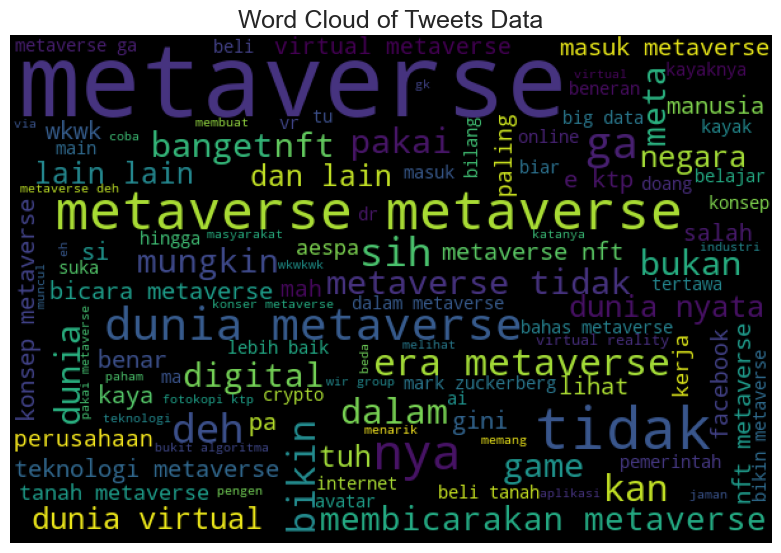

In [9]:
#visualize word cloud

list_words=''
for tweet in tweets['text_preprocessed']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

#### Sentiment analysis Using LSTM

###### Preprocessing Text Data

In [10]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = tweets['text_preprocessed'].apply(lambda x: toSentence(x))
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(47004, 79)

In [11]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = tweets['indonlp_sentiment'].map(polarity_encode).values
y = y.astype(int)

# Split the data (with composition data train 80%, data test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(37603, 79) (37603,)
(9401, 79) (9401,)


In [12]:
np.unique(tweets['indonlp_sentiment'])

array(['negative', 'neutral', 'positive'], dtype=object)

##### LSTM Model

In [14]:
def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [ ]:
'''
# Hyperparameter tuning (to know the best hyperparameter for this model)

# Wrapper model with default hyperparameter values
model = KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128) 

# Hyperparameters
embed_dim = [32, 64]
hidden_unit = [16, 32, 64]
dropout_rate = [0.2]
optimizers = [Adam, RMSprop]
learning_rate = [0.01, 0.001, 0.0001]
epochs = [10, 25]
batch_size = [128, 256]
param_grid = dict(embed_dim = embed_dim, hidden_unit = hidden_unit, dropout_rate = dropout_rate, 
                  learning_rate = learning_rate, optimizers = optimizers, epochs = epochs, batch_size = batch_size)

# Evaluation model with GridSearchCV to know what the best hyperparameter for model 
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)
grid_result = grid.fit(X_train, y_train)

results = pd.DataFrame()
results['means'] = grid_result.cv_results_['mean_test_score']
results['stds'] = grid_result.cv_results_['std_test_score']
results['params'] = grid_result.cv_results_['params']
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
results.to_csv(r'gridsearchcv_results_lexicon.csv', index = False, header = True)
results.sort_values(by='means', ascending = False).reset_index(drop=True)
'''

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_1936\828351765.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 32)            160000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


C:\Users\Juniarta\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


196/196 [==============================] - 8s 28ms/step - loss: 0.8211 - accuracy: 0.6195
Epoch 2/10
196/196 [==============================] - 6s 29ms/step - loss: 0.6634 - accuracy: 0.7255
Epoch 3/10
196/196 [==============================] - 6s 29ms/step - loss: 0.5763 - accuracy: 0.7665
Epoch 4/10
196/196 [==============================] - 6s 32ms/step - loss: 0.4964 - accuracy: 0.7970
Epoch 5/10
196/196 [==============================] - 6s 33ms/step - loss: 0.4337 - accuracy: 0.8226
Epoch 6/10
196/196 [==============================] - 6s 31ms/step - loss: 0.3805 - accuracy: 0.8410
Epoch 7/10
196/196 [==============================] - 6s 30ms/step - loss: 0.3395 - accuracy: 0.8606
Epoch 8/10
196/196 [==============================] - 6s 31ms/step - loss: 0.2986 - accuracy: 0.8776
Epoch 9/10
196/196 [==============================] - 6s 31ms/step - loss: 0.2744 - accuracy: 0.8879
Epoch 10/10
98/98 [==============================] - 2s 9ms/step - loss: 1.5257 - accuracy: 0.6422
Mod

C:\Users\Juniarta\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


196/196 [==============================] - 9s 31ms/step - loss: 0.8074 - accuracy: 0.6316
Epoch 2/10
196/196 [==============================] - 6s 33ms/step - loss: 0.6785 - accuracy: 0.7161
Epoch 3/10
196/196 [==============================] - 6s 32ms/step - loss: 0.6196 - accuracy: 0.7441
Epoch 4/10
196/196 [==============================] - 6s 32ms/step - loss: 0.5686 - accuracy: 0.7692
Epoch 5/10
196/196 [==============================] - 6s 32ms/step - loss: 0.5172 - accuracy: 0.7924
Epoch 6/10
196/196 [==============================] - 6s 33ms/step - loss: 0.4781 - accuracy: 0.8082
Epoch 7/10
196/196 [==============================] - 6s 30ms/step - loss: 0.4417 - accuracy: 0.8261
Epoch 8/10
196/196 [==============================] - 6s 31ms/step - loss: 0.4034 - accuracy: 0.8428
Epoch 9/10
196/196 [==============================] - 6s 33ms/step - loss: 0.3708 - accuracy: 0.8550
Epoch 10/10
98/98 [==============================] - 2s 10ms/step - loss: 1.0893 - accuracy: 0.6561
Mo

None
Epoch 1/10
196/196 [==============================] - 8s 30ms/step - loss: 0.9382 - accuracy: 0.5150
Epoch 2/10
196/196 [==============================] - 6s 31ms/step - loss: 0.7529 - accuracy: 0.6788
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 0.6611 - accuracy: 0.7327
Epoch 4/10
196/196 [==============================] - 6s 31ms/step - loss: 0.6152 - accuracy: 0.7543
Epoch 5/10
196/196 [==============================] - 6s 31ms/step - loss: 0.5833 - accuracy: 0.7689
Epoch 6/10
196/196 [==============================] - 6s 33ms/step - loss: 0.5557 - accuracy: 0.7814
Epoch 7/10
196/196 [==============================] - 6s 32ms/step - loss: 0.5295 - accuracy: 0.7918
Epoch 8/10
196/196 [==============================] - 6s 32ms/step - loss: 0.5043 - accuracy: 0.8040
Epoch 9/10
196/196 [==============================] - 6s 31ms/step - loss: 0.4814 - accuracy: 0.8130
Epoch 10/10
98/98 [==============================] - 2s 10ms/step - loss: 0.9255 - acc

None
Epoch 1/10
196/196 [==============================] - 8s 27ms/step - loss: 0.9233 - accuracy: 0.5260
Epoch 2/10
196/196 [==============================] - 6s 29ms/step - loss: 0.7777 - accuracy: 0.6605
Epoch 3/10
196/196 [==============================] - 6s 29ms/step - loss: 0.7038 - accuracy: 0.7076
Epoch 4/10
196/196 [==============================] - 6s 29ms/step - loss: 0.6662 - accuracy: 0.7311
Epoch 5/10
196/196 [==============================] - 6s 29ms/step - loss: 0.6424 - accuracy: 0.7410
Epoch 6/10
196/196 [==============================] - 6s 29ms/step - loss: 0.6224 - accuracy: 0.7491
Epoch 7/10
196/196 [==============================] - 6s 29ms/step - loss: 0.6076 - accuracy: 0.7553
Epoch 8/10
196/196 [==============================] - 6s 29ms/step - loss: 0.5949 - accuracy: 0.7625
Epoch 9/10
196/196 [==============================] - 6s 29ms/step - loss: 0.5807 - accuracy: 0.7687
Epoch 10/10
98/98 [==============================] - 1s 9ms/step - loss: 0.7964 - accu

None
Epoch 1/10
196/196 [==============================] - 8s 29ms/step - loss: 1.0695 - accuracy: 0.4549
Epoch 2/10
196/196 [==============================] - 6s 31ms/step - loss: 0.9918 - accuracy: 0.4709
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 0.9596 - accuracy: 0.4813
Epoch 4/10
196/196 [==============================] - 6s 31ms/step - loss: 0.9497 - accuracy: 0.4841
Epoch 5/10
196/196 [==============================] - 6s 31ms/step - loss: 0.9353 - accuracy: 0.5006
Epoch 6/10
196/196 [==============================] - 6s 31ms/step - loss: 0.9211 - accuracy: 0.5189
Epoch 7/10
196/196 [==============================] - 6s 31ms/step - loss: 0.9036 - accuracy: 0.5366
Epoch 8/10
196/196 [==============================] - 6s 31ms/step - loss: 0.8883 - accuracy: 0.5599
Epoch 9/10
196/196 [==============================] - 6s 31ms/step - loss: 0.8678 - accuracy: 0.5876
Epoch 10/10
98/98 [==============================] - 2s 10ms/step - loss: 0.8297 - acc

None
Epoch 1/10
196/196 [==============================] - 9s 32ms/step - loss: 0.8045 - accuracy: 0.6350
Epoch 2/10
196/196 [==============================] - 6s 33ms/step - loss: 0.6521 - accuracy: 0.7309
Epoch 3/10
196/196 [==============================] - 6s 33ms/step - loss: 0.5654 - accuracy: 0.7714
Epoch 4/10
196/196 [==============================] - 6s 33ms/step - loss: 0.4907 - accuracy: 0.7974
Epoch 5/10
196/196 [==============================] - 6s 33ms/step - loss: 0.4254 - accuracy: 0.8229
Epoch 6/10
196/196 [==============================] - 7s 33ms/step - loss: 0.3657 - accuracy: 0.8477
Epoch 7/10
196/196 [==============================] - 6s 33ms/step - loss: 0.3259 - accuracy: 0.8648
Epoch 8/10
196/196 [==============================] - 6s 33ms/step - loss: 0.2931 - accuracy: 0.8810
Epoch 9/10
196/196 [==============================] - 7s 36ms/step - loss: 0.2642 - accuracy: 0.8925
Epoch 10/10
98/98 [==============================] - 2s 12ms/step - loss: 1.6864 - acc

None
Epoch 1/10
196/196 [==============================] - 8s 32ms/step - loss: 0.8054 - accuracy: 0.6340
Epoch 2/10
196/196 [==============================] - 6s 33ms/step - loss: 0.6725 - accuracy: 0.7212
Epoch 3/10
196/196 [==============================] - 6s 33ms/step - loss: 0.6153 - accuracy: 0.7488
Epoch 4/10
196/196 [==============================] - 6s 33ms/step - loss: 0.5600 - accuracy: 0.7738
Epoch 5/10
196/196 [==============================] - 6s 33ms/step - loss: 0.5135 - accuracy: 0.7912
Epoch 6/10
196/196 [==============================] - 6s 33ms/step - loss: 0.4690 - accuracy: 0.8120
Epoch 7/10
196/196 [==============================] - 6s 33ms/step - loss: 0.4265 - accuracy: 0.8300
Epoch 8/10
196/196 [==============================] - 6s 33ms/step - loss: 0.3832 - accuracy: 0.8474
Epoch 9/10
196/196 [==============================] - 6s 33ms/step - loss: 0.3477 - accuracy: 0.8653
Epoch 10/10
98/98 [==============================] - 2s 12ms/step - loss: 1.2009 - acc

None
Epoch 1/10
196/196 [==============================] - 9s 31ms/step - loss: 0.9092 - accuracy: 0.5422
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 0.7621 - accuracy: 0.6707
Epoch 3/10
196/196 [==============================] - 6s 32ms/step - loss: 0.6936 - accuracy: 0.7108
Epoch 4/10
196/196 [==============================] - 6s 33ms/step - loss: 0.6600 - accuracy: 0.7258
Epoch 5/10
196/196 [==============================] - 6s 32ms/step - loss: 0.6371 - accuracy: 0.7365
Epoch 6/10
196/196 [==============================] - 6s 32ms/step - loss: 0.6191 - accuracy: 0.7472
Epoch 7/10
196/196 [==============================] - 6s 32ms/step - loss: 0.6050 - accuracy: 0.7543
Epoch 8/10
196/196 [==============================] - 6s 32ms/step - loss: 0.5910 - accuracy: 0.7577
Epoch 9/10
196/196 [==============================] - 6s 32ms/step - loss: 0.5809 - accuracy: 0.7644
Epoch 10/10
98/98 [==============================] - 2s 12ms/step - loss: 0.7711 - acc

None
Epoch 1/10
196/196 [==============================] - 8s 31ms/step - loss: 1.0300 - accuracy: 0.4786
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 0.9538 - accuracy: 0.4851
Epoch 3/10
196/196 [==============================] - 6s 33ms/step - loss: 0.9331 - accuracy: 0.5023
Epoch 4/10
196/196 [==============================] - 6s 33ms/step - loss: 0.9119 - accuracy: 0.5202
Epoch 5/10
196/196 [==============================] - 6s 33ms/step - loss: 0.8890 - accuracy: 0.5559
Epoch 6/10
196/196 [==============================] - 6s 32ms/step - loss: 0.8585 - accuracy: 0.5954
Epoch 7/10
196/196 [==============================] - 6s 32ms/step - loss: 0.8209 - accuracy: 0.6342
Epoch 8/10
196/196 [==============================] - 6s 32ms/step - loss: 0.7928 - accuracy: 0.6566
Epoch 9/10
196/196 [==============================] - 6s 32ms/step - loss: 0.7677 - accuracy: 0.6714
Epoch 10/10
98/98 [==============================] - 2s 11ms/step - loss: 0.7972 - acc

None
Epoch 1/10
196/196 [==============================] - 8s 31ms/step - loss: 1.0328 - accuracy: 0.4736
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 0.9544 - accuracy: 0.4892
Epoch 3/10
196/196 [==============================] - 6s 32ms/step - loss: 0.9430 - accuracy: 0.5018
Epoch 4/10
196/196 [==============================] - 6s 32ms/step - loss: 0.9265 - accuracy: 0.5213
Epoch 5/10
196/196 [==============================] - 6s 32ms/step - loss: 0.9060 - accuracy: 0.5496
Epoch 6/10
196/196 [==============================] - 6s 32ms/step - loss: 0.8861 - accuracy: 0.5853
Epoch 7/10
196/196 [==============================] - 6s 32ms/step - loss: 0.8634 - accuracy: 0.6150
Epoch 8/10
196/196 [==============================] - 6s 32ms/step - loss: 0.8411 - accuracy: 0.6335
Epoch 9/10
196/196 [==============================] - 6s 32ms/step - loss: 0.8220 - accuracy: 0.6441
Epoch 10/10
98/98 [==============================] - 2s 12ms/step - loss: 0.8233 - acc

None
Epoch 1/10
196/196 [==============================] - 11s 42ms/step - loss: 0.8138 - accuracy: 0.6275
Epoch 2/10
196/196 [==============================] - 9s 44ms/step - loss: 0.6831 - accuracy: 0.7150
Epoch 3/10
196/196 [==============================] - 9s 44ms/step - loss: 0.6195 - accuracy: 0.7433
Epoch 4/10
196/196 [==============================] - 9s 44ms/step - loss: 0.5604 - accuracy: 0.7719
Epoch 5/10
196/196 [==============================] - 9s 43ms/step - loss: 0.5019 - accuracy: 0.7985
Epoch 6/10
196/196 [==============================] - 9s 44ms/step - loss: 0.4429 - accuracy: 0.8232
Epoch 7/10
196/196 [==============================] - 9s 44ms/step - loss: 0.3876 - accuracy: 0.8431
Epoch 8/10
196/196 [==============================] - 9s 44ms/step - loss: 0.3393 - accuracy: 0.8672
Epoch 9/10
196/196 [==============================] - 9s 44ms/step - loss: 0.2928 - accuracy: 0.8858
Epoch 10/10
98/98 [==============================] - 2s 17ms/step - loss: 1.4328 - ac

None
Epoch 1/10
196/196 [==============================] - 10s 42ms/step - loss: 0.8896 - accuracy: 0.5615
Epoch 2/10
196/196 [==============================] - 9s 44ms/step - loss: 0.7054 - accuracy: 0.7027
Epoch 3/10
196/196 [==============================] - 9s 44ms/step - loss: 0.6360 - accuracy: 0.7431
Epoch 4/10
196/196 [==============================] - 9s 44ms/step - loss: 0.5978 - accuracy: 0.7551
Epoch 5/10
196/196 [==============================] - 9s 44ms/step - loss: 0.5668 - accuracy: 0.7694
Epoch 6/10
196/196 [==============================] - 9s 44ms/step - loss: 0.5429 - accuracy: 0.7796
Epoch 7/10
196/196 [==============================] - 9s 44ms/step - loss: 0.5183 - accuracy: 0.7884
Epoch 8/10
196/196 [==============================] - 9s 44ms/step - loss: 0.4875 - accuracy: 0.8011
Epoch 9/10
196/196 [==============================] - 9s 44ms/step - loss: 0.4533 - accuracy: 0.8147
Epoch 10/10
98/98 [==============================] - 2s 17ms/step - loss: 1.0561 - ac

None
Epoch 1/10
196/196 [==============================] - 10s 42ms/step - loss: 0.8931 - accuracy: 0.5514
Epoch 2/10
196/196 [==============================] - 8s 43ms/step - loss: 0.7418 - accuracy: 0.6817
Epoch 3/10
196/196 [==============================] - 9s 44ms/step - loss: 0.6825 - accuracy: 0.7171
Epoch 4/10
196/196 [==============================] - 8s 43ms/step - loss: 0.6506 - accuracy: 0.7339
Epoch 5/10
196/196 [==============================] - 8s 43ms/step - loss: 0.6348 - accuracy: 0.7412
Epoch 6/10
196/196 [==============================] - 8s 43ms/step - loss: 0.6120 - accuracy: 0.7519
Epoch 7/10
196/196 [==============================] - 8s 43ms/step - loss: 0.6024 - accuracy: 0.7557
Epoch 8/10
196/196 [==============================] - 8s 43ms/step - loss: 0.5865 - accuracy: 0.7600
Epoch 9/10
196/196 [==============================] - 8s 43ms/step - loss: 0.5765 - accuracy: 0.7663
Epoch 10/10
98/98 [==============================] - 2s 17ms/step - loss: 0.7849 - ac

None
Epoch 1/10
196/196 [==============================] - 11s 45ms/step - loss: 0.9973 - accuracy: 0.4883
Epoch 2/10
196/196 [==============================] - 9s 46ms/step - loss: 0.9539 - accuracy: 0.4914
Epoch 3/10
196/196 [==============================] - 8s 43ms/step - loss: 0.9407 - accuracy: 0.4968
Epoch 4/10
196/196 [==============================] - 8s 42ms/step - loss: 0.9253 - accuracy: 0.5150
Epoch 5/10
196/196 [==============================] - 8s 42ms/step - loss: 0.9074 - accuracy: 0.5374
Epoch 6/10
196/196 [==============================] - 8s 43ms/step - loss: 0.8813 - accuracy: 0.5773
Epoch 7/10
196/196 [==============================] - 9s 44ms/step - loss: 0.8600 - accuracy: 0.6020
Epoch 8/10
196/196 [==============================] - 8s 43ms/step - loss: 0.8416 - accuracy: 0.6188
Epoch 9/10
196/196 [==============================] - 8s 43ms/step - loss: 0.8237 - accuracy: 0.6322
Epoch 10/10
98/98 [==============================] - 2s 17ms/step - loss: 0.8078 - ac

 lstm_57 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_57 (Dropout)        (None, 16)                0         
                                                                 
 dense_57 (Dense)            (None, 3)                 51        
                                                                 
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 8s 28ms/step - loss: 0.8051 - accuracy: 0.6363
Epoch 2/25
196/196 [==============================] - 6s 29ms/step - loss: 0.6820 - accuracy: 0.7140
Epoch 3/25
196/196 [==============================] - 6s 29ms/step - loss: 0.6197 - accuracy: 0.7451
Epoch 4/25
196/196 [==============================] - 6s 29ms/step - loss: 0.5635 - accuracy: 0.7711
Epoch 5/25
196/196 [==============================] - 6s 

196/196 [==============================] - 6s 28ms/step - loss: 0.3487 - accuracy: 0.8630
Epoch 16/25
196/196 [==============================] - 6s 28ms/step - loss: 0.3382 - accuracy: 0.8666
Epoch 17/25
196/196 [==============================] - 6s 28ms/step - loss: 0.3265 - accuracy: 0.8717
Epoch 18/25
196/196 [==============================] - 6s 29ms/step - loss: 0.3135 - accuracy: 0.8771
Epoch 19/25
196/196 [==============================] - 6s 28ms/step - loss: 0.2975 - accuracy: 0.8827
Epoch 20/25
196/196 [==============================] - 6s 28ms/step - loss: 0.2883 - accuracy: 0.8863
Epoch 21/25
196/196 [==============================] - 6s 28ms/step - loss: 0.2903 - accuracy: 0.8868
Epoch 22/25
196/196 [==============================] - 6s 28ms/step - loss: 0.2713 - accuracy: 0.8931
Epoch 23/25
196/196 [==============================] - 6s 28ms/step - loss: 0.2598 - accuracy: 0.8984
Epoch 24/25
196/196 [==============================] - 6s 28ms/step - loss: 0.2515 - accuracy:

Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 8s 27ms/step - loss: 1.0396 - accuracy: 0.4499
Epoch 2/25
196/196 [==============================] - 6s 28ms/step - loss: 0.9636 - accuracy: 0.4785
Epoch 3/25
196/196 [==============================] - 6s 29ms/step - loss: 0.9494 - accuracy: 0.4929
Epoch 4/25
196/196 [==============================] - 6s 28ms/step - loss: 0.9293 - accuracy: 0.5103
Epoch 5/25
196/196 [==============================] - 6s 29ms/step - loss: 0.9079 - accuracy: 0.5317
Epoch 6/25
196/196 [==============================] - 6s 28ms/step - loss: 0.8896 - accuracy: 0.5624
Epoch 7/25
196/196 [==============================] - 6s 28ms/step - loss: 0.8657 - accuracy: 0.5965
Epoch 8/25
196/196 [==============================] - 6s 28ms/step - loss: 0.8415 - accuracy: 0.6222
Epoch 9/25
196/196 [==============================] - 6s 29ms/step - loss: 0.8154 - accuracy: 0.6

196/196 [==============================] - 6s 28ms/step - loss: 0.7233 - accuracy: 0.6993
Epoch 21/25
196/196 [==============================] - 6s 28ms/step - loss: 0.7165 - accuracy: 0.7013
Epoch 22/25
196/196 [==============================] - 6s 28ms/step - loss: 0.7081 - accuracy: 0.7051
Epoch 23/25
196/196 [==============================] - 6s 28ms/step - loss: 0.7015 - accuracy: 0.7096
Epoch 24/25
196/196 [==============================] - 6s 29ms/step - loss: 0.6949 - accuracy: 0.7137
Epoch 25/25
98/98 [==============================] - 1s 9ms/step - loss: 0.7753 - accuracy: 0.6611
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_71 (Embedding)    (None, 79, 32)            160000    
                                                                 
 lstm_71 (LSTM)              (None, 16)                3136      
                                                  

 lstm_73 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_73 (Dropout)        (None, 32)                0         
                                                                 
 dense_73 (Dense)            (None, 3)                 99        
                                                                 
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 8s 30ms/step - loss: 0.7972 - accuracy: 0.6377
Epoch 2/25
196/196 [==============================] - 6s 32ms/step - loss: 0.6511 - accuracy: 0.7348
Epoch 3/25
196/196 [==============================] - 6s 32ms/step - loss: 0.5629 - accuracy: 0.7717
Epoch 4/25
196/196 [==============================] - 6s 32ms/step - loss: 0.4816 - accuracy: 0.8037
Epoch 5/25
196/196 [==============================] - 6s 

196/196 [==============================] - 6s 31ms/step - loss: 0.5265 - accuracy: 0.7872
Epoch 6/25
196/196 [==============================] - 6s 31ms/step - loss: 0.4808 - accuracy: 0.8057
Epoch 7/25
196/196 [==============================] - 6s 31ms/step - loss: 0.4323 - accuracy: 0.8278
Epoch 8/25
196/196 [==============================] - 6s 32ms/step - loss: 0.3884 - accuracy: 0.8461
Epoch 9/25
196/196 [==============================] - 6s 31ms/step - loss: 0.3512 - accuracy: 0.8638
Epoch 10/25
196/196 [==============================] - 6s 32ms/step - loss: 0.3149 - accuracy: 0.8780
Epoch 11/25
196/196 [==============================] - 6s 31ms/step - loss: 0.2824 - accuracy: 0.8907
Epoch 12/25
196/196 [==============================] - 6s 32ms/step - loss: 0.2539 - accuracy: 0.9020
Epoch 13/25
196/196 [==============================] - 6s 31ms/step - loss: 0.2221 - accuracy: 0.9142
Epoch 14/25
196/196 [==============================] - 6s 31ms/step - loss: 0.2042 - accuracy: 0.9

98/98 [==============================] - 2s 11ms/step - loss: 2.0459 - accuracy: 0.6223
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_80 (Embedding)    (None, 79, 32)            160000    
                                                                 
 lstm_80 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_80 (Dropout)        (None, 32)                0         
                                                                 
 dense_80 (Dense)            (None, 3)                 99        
                                                                 
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 8s 31ms/step - loss: 0.9081 - ac

Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 8s 30ms/step - loss: 0.8995 - accuracy: 0.5628
Epoch 2/25
196/196 [==============================] - 6s 32ms/step - loss: 0.7558 - accuracy: 0.6717
Epoch 3/25
196/196 [==============================] - 6s 32ms/step - loss: 0.6881 - accuracy: 0.7142
Epoch 4/25
196/196 [==============================] - 6s 32ms/step - loss: 0.6559 - accuracy: 0.7337
Epoch 5/25
196/196 [==============================] - 6s 32ms/step - loss: 0.6320 - accuracy: 0.7442
Epoch 6/25
196/196 [==============================] - 6s 32ms/step - loss: 0.6166 - accuracy: 0.7511
Epoch 7/25
196/196 [==============================] - 6s 32ms/step - loss: 0.6025 - accuracy: 0.7543
Epoch 8/25
196/196 [==============================] - 6s 32ms/step - loss: 0.5917 - accuracy: 0.7616
Epoch 9/25
196/196 [==============================] - 6s 32ms/step - loss: 0.5803 - accuracy: 0.7

196/196 [==============================] - 6s 32ms/step - loss: 0.6179 - accuracy: 0.7494
Epoch 21/25
196/196 [==============================] - 6s 32ms/step - loss: 0.6133 - accuracy: 0.7523
Epoch 22/25
196/196 [==============================] - 6s 32ms/step - loss: 0.6046 - accuracy: 0.7551
Epoch 23/25
196/196 [==============================] - 6s 32ms/step - loss: 0.5988 - accuracy: 0.7596
Epoch 24/25
196/196 [==============================] - 6s 32ms/step - loss: 0.5929 - accuracy: 0.7649
Epoch 25/25
98/98 [==============================] - 2s 12ms/step - loss: 0.8083 - accuracy: 0.6780
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_87 (Embedding)    (None, 79, 32)            160000    
                                                                 
 lstm_87 (LSTM)              (None, 32)                8320      
                                                 

 lstm_89 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_89 (Dropout)        (None, 32)                0         
                                                                 
 dense_89 (Dense)            (None, 3)                 99        
                                                                 
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 8s 30ms/step - loss: 1.0237 - accuracy: 0.4748
Epoch 2/25
196/196 [==============================] - 6s 31ms/step - loss: 0.9516 - accuracy: 0.4889
Epoch 3/25
196/196 [==============================] - 6s 31ms/step - loss: 0.9357 - accuracy: 0.4979
Epoch 4/25
196/196 [==============================] - 6s 32ms/step - loss: 0.9208 - accuracy: 0.5099
Epoch 5/25
196/196 [==============================] - 6s 

196/196 [==============================] - 8s 42ms/step - loss: 0.4213 - accuracy: 0.8280
Epoch 6/25
196/196 [==============================] - 8s 42ms/step - loss: 0.3624 - accuracy: 0.8520
Epoch 7/25
196/196 [==============================] - 8s 42ms/step - loss: 0.3142 - accuracy: 0.8714
Epoch 8/25
196/196 [==============================] - 8s 42ms/step - loss: 0.2783 - accuracy: 0.8883
Epoch 9/25
196/196 [==============================] - 8s 42ms/step - loss: 0.2529 - accuracy: 0.8964
Epoch 10/25
196/196 [==============================] - 8s 42ms/step - loss: 0.2209 - accuracy: 0.9110
Epoch 11/25
196/196 [==============================] - 8s 42ms/step - loss: 0.1894 - accuracy: 0.9240
Epoch 12/25
196/196 [==============================] - 8s 43ms/step - loss: 0.1758 - accuracy: 0.9306
Epoch 13/25
196/196 [==============================] - 8s 42ms/step - loss: 0.1640 - accuracy: 0.9343
Epoch 14/25
196/196 [==============================] - 8s 42ms/step - loss: 0.1520 - accuracy: 0.9

98/98 [==============================] - 2s 17ms/step - loss: 2.4070 - accuracy: 0.6187
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_96 (Embedding)    (None, 79, 32)            160000    
                                                                 
 lstm_96 (LSTM)              (None, 64)                24832     
                                                                 
 dropout_96 (Dropout)        (None, 64)                0         
                                                                 
 dense_96 (Dense)            (None, 3)                 195       
                                                                 
Total params: 185,027
Trainable params: 185,027
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 10s 40ms/step - loss: 0.8988 - a

Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 10s 41ms/step - loss: 0.8888 - accuracy: 0.5611
Epoch 2/25
196/196 [==============================] - 8s 42ms/step - loss: 0.7023 - accuracy: 0.7042
Epoch 3/25
196/196 [==============================] - 8s 43ms/step - loss: 0.6358 - accuracy: 0.7390
Epoch 4/25
196/196 [==============================] - 8s 43ms/step - loss: 0.5971 - accuracy: 0.7586
Epoch 5/25
196/196 [==============================] - 8s 43ms/step - loss: 0.5677 - accuracy: 0.7700
Epoch 6/25
196/196 [==============================] - 8s 43ms/step - loss: 0.5460 - accuracy: 0.7788
Epoch 7/25
196/196 [==============================] - 8s 43ms/step - loss: 0.5266 - accuracy: 0.7871
Epoch 8/25
196/196 [==============================] - 8s 42ms/step - loss: 0.5026 - accuracy: 0.7977
Epoch 9/25
196/196 [==============================] - 8s 43ms/step - loss: 0.4774 - accuracy: 0.

196/196 [==============================] - 8s 42ms/step - loss: 0.5595 - accuracy: 0.7758
Epoch 11/25
196/196 [==============================] - 8s 42ms/step - loss: 0.5489 - accuracy: 0.7809
Epoch 12/25
196/196 [==============================] - 8s 42ms/step - loss: 0.5376 - accuracy: 0.7846
Epoch 13/25
196/196 [==============================] - 8s 42ms/step - loss: 0.5253 - accuracy: 0.7884
Epoch 14/25
196/196 [==============================] - 8s 43ms/step - loss: 0.5119 - accuracy: 0.7956
Epoch 15/25
196/196 [==============================] - 8s 42ms/step - loss: 0.4991 - accuracy: 0.8006
Epoch 16/25
196/196 [==============================] - 8s 42ms/step - loss: 0.4862 - accuracy: 0.8051
Epoch 17/25
196/196 [==============================] - 8s 42ms/step - loss: 0.4730 - accuracy: 0.8114
Epoch 18/25
196/196 [==============================] - 8s 42ms/step - loss: 0.4600 - accuracy: 0.8167
Epoch 19/25
196/196 [==============================] - 8s 42ms/step - loss: 0.4476 - accuracy:

196/196 [==============================] - 8s 41ms/step - loss: 0.5745 - accuracy: 0.7637
Epoch 21/25
196/196 [==============================] - 8s 41ms/step - loss: 0.5687 - accuracy: 0.7688
Epoch 22/25
196/196 [==============================] - 8s 41ms/step - loss: 0.5585 - accuracy: 0.7690
Epoch 23/25
196/196 [==============================] - 8s 42ms/step - loss: 0.5516 - accuracy: 0.7746
Epoch 24/25
196/196 [==============================] - 8s 42ms/step - loss: 0.5449 - accuracy: 0.7799
Epoch 25/25
98/98 [==============================] - 2s 17ms/step - loss: 0.8262 - accuracy: 0.6768
Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_103 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_103 (LSTM)             (None, 64)                24832     
                                                

 lstm_105 (LSTM)             (None, 64)                24832     
                                                                 
 dropout_105 (Dropout)       (None, 64)                0         
                                                                 
 dense_105 (Dense)           (None, 3)                 195       
                                                                 
Total params: 185,027
Trainable params: 185,027
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 11s 41ms/step - loss: 1.0076 - accuracy: 0.4813
Epoch 2/25
196/196 [==============================] - 8s 42ms/step - loss: 0.9556 - accuracy: 0.4851
Epoch 3/25
196/196 [==============================] - 8s 42ms/step - loss: 0.9376 - accuracy: 0.5015
Epoch 4/25
196/196 [==============================] - 8s 42ms/step - loss: 0.9153 - accuracy: 0.5321
Epoch 5/25
196/196 [==============================] - 8s

196/196 [==============================] - 8s 42ms/step - loss: 0.9107 - accuracy: 0.5092
Epoch 6/25
196/196 [==============================] - 8s 42ms/step - loss: 0.8955 - accuracy: 0.5307
Epoch 7/25
196/196 [==============================] - 8s 42ms/step - loss: 0.8748 - accuracy: 0.5810
Epoch 8/25
196/196 [==============================] - 8s 42ms/step - loss: 0.8463 - accuracy: 0.6231
Epoch 9/25
196/196 [==============================] - 8s 42ms/step - loss: 0.8227 - accuracy: 0.6359
Epoch 10/25
196/196 [==============================] - 8s 42ms/step - loss: 0.8021 - accuracy: 0.6512
Epoch 11/25
196/196 [==============================] - 8s 42ms/step - loss: 0.7844 - accuracy: 0.6575
Epoch 12/25
196/196 [==============================] - 8s 42ms/step - loss: 0.7663 - accuracy: 0.6665
Epoch 13/25
196/196 [==============================] - 8s 42ms/step - loss: 0.7490 - accuracy: 0.6769
Epoch 14/25
196/196 [==============================] - 8s 42ms/step - loss: 0.7321 - accuracy: 0.6

Epoch 10/10
98/98 [==============================] - 1s 9ms/step - loss: 1.5793 - accuracy: 0.6462
Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_111 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_111 (LSTM)             (None, 16)                5184      
                                                                 
 dropout_111 (Dropout)       (None, 16)                0         
                                                                 
 dense_111 (Dense)           (None, 3)                 51        
                                                                 
Total params: 325,235
Trainable params: 325,235
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 [==============================] - 8s 29ms/step - loss:

196/196 [==============================] - 6s 30ms/step - loss: 0.5791 - accuracy: 0.7683
Epoch 9/10
196/196 [==============================] - 6s 30ms/step - loss: 0.5622 - accuracy: 0.7779
Epoch 10/10
98/98 [==============================] - 2s 9ms/step - loss: 0.7958 - accuracy: 0.6775
Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_119 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_119 (LSTM)             (None, 16)                5184      
                                                                 
 dropout_119 (Dropout)       (None, 16)                0         
                                                                 
 dense_119 (Dense)           (None, 3)                 51        
                                                                 
Total params: 325,235
Trai

196/196 [==============================] - 7s 34ms/step - loss: 0.3363 - accuracy: 0.8628
Epoch 7/10
196/196 [==============================] - 7s 35ms/step - loss: 0.2942 - accuracy: 0.8806
Epoch 8/10
196/196 [==============================] - 7s 35ms/step - loss: 0.2613 - accuracy: 0.8966
Epoch 9/10
196/196 [==============================] - 7s 34ms/step - loss: 0.2221 - accuracy: 0.9097
Epoch 10/10
98/98 [==============================] - 2s 12ms/step - loss: 1.7360 - accuracy: 0.6386
Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_127 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_127 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_127 (Dropout)       (None, 32)                0         
                     

196/196 [==============================] - 7s 35ms/step - loss: 0.5886 - accuracy: 0.7631
Epoch 5/10
196/196 [==============================] - 7s 35ms/step - loss: 0.5575 - accuracy: 0.7756
Epoch 6/10
196/196 [==============================] - 7s 35ms/step - loss: 0.5274 - accuracy: 0.7887
Epoch 7/10
196/196 [==============================] - 7s 35ms/step - loss: 0.4917 - accuracy: 0.8053
Epoch 8/10
196/196 [==============================] - 7s 35ms/step - loss: 0.4587 - accuracy: 0.8184
Epoch 9/10
196/196 [==============================] - 7s 35ms/step - loss: 0.4271 - accuracy: 0.8299
Epoch 10/10
98/98 [==============================] - 2s 12ms/step - loss: 1.1275 - accuracy: 0.6545
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_135 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_135 (LSTM) 

196/196 [==============================] - 7s 34ms/step - loss: 0.9551 - accuracy: 0.4930
Epoch 3/10
196/196 [==============================] - 7s 34ms/step - loss: 0.9348 - accuracy: 0.5072
Epoch 4/10
196/196 [==============================] - 7s 34ms/step - loss: 0.9132 - accuracy: 0.5285
Epoch 5/10
196/196 [==============================] - 7s 34ms/step - loss: 0.8880 - accuracy: 0.5605
Epoch 6/10
196/196 [==============================] - 7s 34ms/step - loss: 0.8564 - accuracy: 0.6019
Epoch 7/10
196/196 [==============================] - 7s 34ms/step - loss: 0.8242 - accuracy: 0.6305
Epoch 8/10
196/196 [==============================] - 7s 34ms/step - loss: 0.8011 - accuracy: 0.6501
Epoch 9/10
196/196 [==============================] - 7s 34ms/step - loss: 0.7807 - accuracy: 0.6617
Epoch 10/10
98/98 [==============================] - 2s 12ms/step - loss: 0.7971 - accuracy: 0.6438
Model: "sequential_143"
_________________________________________________________________
 Layer (type)

None
Epoch 1/10
196/196 [==============================] - 11s 44ms/step - loss: 0.8759 - accuracy: 0.5751
Epoch 2/10
196/196 [==============================] - 9s 46ms/step - loss: 0.6939 - accuracy: 0.7083
Epoch 3/10
196/196 [==============================] - 9s 46ms/step - loss: 0.6267 - accuracy: 0.7407
Epoch 4/10
196/196 [==============================] - 9s 46ms/step - loss: 0.5854 - accuracy: 0.7579
Epoch 5/10
196/196 [==============================] - 9s 47ms/step - loss: 0.5468 - accuracy: 0.7745
Epoch 6/10
196/196 [==============================] - 9s 46ms/step - loss: 0.5049 - accuracy: 0.7944
Epoch 7/10
196/196 [==============================] - 9s 46ms/step - loss: 0.4635 - accuracy: 0.8098
Epoch 8/10
196/196 [==============================] - 9s 46ms/step - loss: 0.4260 - accuracy: 0.8262
Epoch 9/10
196/196 [==============================] - 9s 46ms/step - loss: 0.3945 - accuracy: 0.8386
Epoch 10/10
98/98 [==============================] - 2s 18ms/step - loss: 1.2795 - ac

None
Epoch 1/10
196/196 [==============================] - 11s 44ms/step - loss: 0.8779 - accuracy: 0.5663
Epoch 2/10
196/196 [==============================] - 9s 45ms/step - loss: 0.7192 - accuracy: 0.6962
Epoch 3/10
196/196 [==============================] - 9s 45ms/step - loss: 0.6623 - accuracy: 0.7252
Epoch 4/10
196/196 [==============================] - 9s 45ms/step - loss: 0.6315 - accuracy: 0.7398
Epoch 5/10
196/196 [==============================] - 9s 46ms/step - loss: 0.6110 - accuracy: 0.7507
Epoch 6/10
196/196 [==============================] - 9s 45ms/step - loss: 0.5956 - accuracy: 0.7596
Epoch 7/10
196/196 [==============================] - 9s 45ms/step - loss: 0.5798 - accuracy: 0.7662
Epoch 8/10
196/196 [==============================] - 9s 45ms/step - loss: 0.5656 - accuracy: 0.7713
Epoch 9/10
196/196 [==============================] - 9s 46ms/step - loss: 0.5475 - accuracy: 0.7802
Epoch 10/10
98/98 [==============================] - 3s 17ms/step - loss: 0.8006 - ac

None
Epoch 1/10
196/196 [==============================] - 11s 45ms/step - loss: 1.0022 - accuracy: 0.4847
Epoch 2/10
196/196 [==============================] - 9s 46ms/step - loss: 0.9351 - accuracy: 0.4999
Epoch 3/10
196/196 [==============================] - 9s 46ms/step - loss: 0.8826 - accuracy: 0.5632
Epoch 4/10
196/196 [==============================] - 9s 46ms/step - loss: 0.8181 - accuracy: 0.6330
Epoch 5/10
196/196 [==============================] - 9s 46ms/step - loss: 0.7682 - accuracy: 0.6701
Epoch 6/10
196/196 [==============================] - 9s 46ms/step - loss: 0.7306 - accuracy: 0.6941
Epoch 7/10
196/196 [==============================] - 9s 46ms/step - loss: 0.6996 - accuracy: 0.7103
Epoch 8/10
196/196 [==============================] - 9s 46ms/step - loss: 0.6765 - accuracy: 0.7226
Epoch 9/10
196/196 [==============================] - 9s 46ms/step - loss: 0.6609 - accuracy: 0.7339
Epoch 10/10
98/98 [==============================] - 2s 18ms/step - loss: 0.7680 - ac

None
Epoch 1/25
196/196 [==============================] - 8s 30ms/step - loss: 0.8157 - accuracy: 0.6273
Epoch 2/25
196/196 [==============================] - 6s 31ms/step - loss: 0.6564 - accuracy: 0.7303
Epoch 3/25
196/196 [==============================] - 6s 31ms/step - loss: 0.5507 - accuracy: 0.7780
Epoch 4/25
196/196 [==============================] - 6s 31ms/step - loss: 0.4696 - accuracy: 0.8090
Epoch 5/25
196/196 [==============================] - 6s 31ms/step - loss: 0.4058 - accuracy: 0.8365
Epoch 6/25
196/196 [==============================] - 6s 31ms/step - loss: 0.3517 - accuracy: 0.8593
Epoch 7/25
196/196 [==============================] - 6s 31ms/step - loss: 0.3096 - accuracy: 0.8767
Epoch 8/25
196/196 [==============================] - 6s 31ms/step - loss: 0.2843 - accuracy: 0.8867
Epoch 9/25
196/196 [==============================] - 6s 31ms/step - loss: 0.2610 - accuracy: 0.8944
Epoch 10/25
196/196 [==============================] - 6s 31ms/step - loss: 0.2348 - a

196/196 [==============================] - 6s 31ms/step - loss: 0.2297 - accuracy: 0.9085
Epoch 12/25
196/196 [==============================] - 6s 31ms/step - loss: 0.2114 - accuracy: 0.9156
Epoch 13/25
196/196 [==============================] - 6s 31ms/step - loss: 0.2132 - accuracy: 0.9167
Epoch 14/25
196/196 [==============================] - 6s 31ms/step - loss: 0.1980 - accuracy: 0.9219
Epoch 15/25
196/196 [==============================] - 6s 31ms/step - loss: 0.1973 - accuracy: 0.9224
Epoch 16/25
196/196 [==============================] - 6s 31ms/step - loss: 0.1814 - accuracy: 0.9287
Epoch 17/25
196/196 [==============================] - 6s 31ms/step - loss: 0.1767 - accuracy: 0.9305
Epoch 18/25
196/196 [==============================] - 6s 31ms/step - loss: 0.1646 - accuracy: 0.9356
Epoch 19/25
196/196 [==============================] - 6s 31ms/step - loss: 0.1552 - accuracy: 0.9400
Epoch 20/25
196/196 [==============================] - 6s 31ms/step - loss: 0.1566 - accuracy:

196/196 [==============================] - 6s 30ms/step - loss: 0.1401 - accuracy: 0.9468
Epoch 22/25
196/196 [==============================] - 6s 30ms/step - loss: 0.1361 - accuracy: 0.9486
Epoch 23/25
196/196 [==============================] - 6s 30ms/step - loss: 0.1297 - accuracy: 0.9506
Epoch 24/25
196/196 [==============================] - 6s 30ms/step - loss: 0.1251 - accuracy: 0.9532
Epoch 25/25
98/98 [==============================] - 2s 10ms/step - loss: 1.8366 - accuracy: 0.6205
Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_167 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_167 (LSTM)             (None, 16)                5184      
                                                                 
 dropout_167 (Dropout)       (None, 16)                0         
                  

 dropout_169 (Dropout)       (None, 16)                0         
                                                                 
 dense_169 (Dense)           (None, 3)                 51        
                                                                 
Total params: 325,235
Trainable params: 325,235
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 8s 30ms/step - loss: 0.8860 - accuracy: 0.5696
Epoch 2/25
196/196 [==============================] - 6s 31ms/step - loss: 0.7035 - accuracy: 0.7108
Epoch 3/25
196/196 [==============================] - 6s 31ms/step - loss: 0.6364 - accuracy: 0.7412
Epoch 4/25
196/196 [==============================] - 6s 31ms/step - loss: 0.5929 - accuracy: 0.7611
Epoch 5/25
196/196 [==============================] - 6s 31ms/step - loss: 0.5619 - accuracy: 0.7732
Epoch 6/25
196/196 [==============================] - 6s 31ms/step - loss: 0.5276 - accu

196/196 [==============================] - 6s 30ms/step - loss: 0.4319 - accuracy: 0.8325
Epoch 17/25
196/196 [==============================] - 6s 31ms/step - loss: 0.4167 - accuracy: 0.8387
Epoch 18/25
196/196 [==============================] - 6s 31ms/step - loss: 0.4005 - accuracy: 0.8453
Epoch 19/25
196/196 [==============================] - 6s 31ms/step - loss: 0.3891 - accuracy: 0.8507
Epoch 20/25
196/196 [==============================] - 6s 30ms/step - loss: 0.3733 - accuracy: 0.8577
Epoch 21/25
196/196 [==============================] - 6s 30ms/step - loss: 0.3629 - accuracy: 0.8627
Epoch 22/25
196/196 [==============================] - 6s 31ms/step - loss: 0.3510 - accuracy: 0.8656
Epoch 23/25
196/196 [==============================] - 6s 31ms/step - loss: 0.3403 - accuracy: 0.8709
Epoch 24/25
196/196 [==============================] - 6s 31ms/step - loss: 0.3300 - accuracy: 0.8750
Epoch 25/25
98/98 [==============================] - 2s 10ms/step - loss: 1.2327 - accuracy: 0

None
Epoch 1/25
196/196 [==============================] - 8s 29ms/step - loss: 1.0541 - accuracy: 0.4204
Epoch 2/25
196/196 [==============================] - 6s 31ms/step - loss: 0.9727 - accuracy: 0.4803
Epoch 3/25
196/196 [==============================] - 6s 30ms/step - loss: 0.9395 - accuracy: 0.5236
Epoch 4/25
196/196 [==============================] - 6s 30ms/step - loss: 0.9127 - accuracy: 0.5593
Epoch 5/25
196/196 [==============================] - 6s 30ms/step - loss: 0.8804 - accuracy: 0.5874
Epoch 6/25
196/196 [==============================] - 6s 30ms/step - loss: 0.8451 - accuracy: 0.6138
Epoch 7/25
196/196 [==============================] - 6s 31ms/step - loss: 0.8169 - accuracy: 0.6394
Epoch 8/25
196/196 [==============================] - 6s 31ms/step - loss: 0.7942 - accuracy: 0.6561
Epoch 9/25
196/196 [==============================] - 6s 30ms/step - loss: 0.7791 - accuracy: 0.6701
Epoch 10/25
196/196 [==============================] - 6s 30ms/step - loss: 0.7638 - a

196/196 [==============================] - 7s 35ms/step - loss: 0.2047 - accuracy: 0.9190
Epoch 12/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1824 - accuracy: 0.9275
Epoch 13/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1697 - accuracy: 0.9314
Epoch 14/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1626 - accuracy: 0.9368
Epoch 15/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1417 - accuracy: 0.9448
Epoch 16/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1378 - accuracy: 0.9469
Epoch 17/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1299 - accuracy: 0.9495
Epoch 18/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1310 - accuracy: 0.9489
Epoch 19/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1240 - accuracy: 0.9519
Epoch 20/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1304 - accuracy:

196/196 [==============================] - 7s 35ms/step - loss: 0.1245 - accuracy: 0.9527
Epoch 22/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1270 - accuracy: 0.9509
Epoch 23/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1247 - accuracy: 0.9517
Epoch 24/25
196/196 [==============================] - 7s 35ms/step - loss: 0.1235 - accuracy: 0.9530
Epoch 25/25
98/98 [==============================] - 2s 12ms/step - loss: 2.6013 - accuracy: 0.6318
Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_183 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_183 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_183 (Dropout)       (None, 32)                0         
                  

 dropout_185 (Dropout)       (None, 32)                0         
                                                                 
 dense_185 (Dense)           (None, 3)                 99        
                                                                 
Total params: 332,515
Trainable params: 332,515
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 9s 33ms/step - loss: 0.7972 - accuracy: 0.6376
Epoch 2/25
196/196 [==============================] - 7s 34ms/step - loss: 0.6649 - accuracy: 0.7273
Epoch 3/25
196/196 [==============================] - 7s 34ms/step - loss: 0.5923 - accuracy: 0.7587
Epoch 4/25
196/196 [==============================] - 7s 34ms/step - loss: 0.5272 - accuracy: 0.7889
Epoch 5/25
196/196 [==============================] - 7s 34ms/step - loss: 0.4739 - accuracy: 0.8113
Epoch 6/25
196/196 [==============================] - 7s 34ms/step - loss: 0.4240 - accu

196/196 [==============================] - 7s 34ms/step - loss: 0.4248 - accuracy: 0.8291
Epoch 17/25
196/196 [==============================] - 7s 34ms/step - loss: 0.4102 - accuracy: 0.8376
Epoch 18/25
196/196 [==============================] - 7s 34ms/step - loss: 0.3950 - accuracy: 0.8440
Epoch 19/25
196/196 [==============================] - 7s 34ms/step - loss: 0.3780 - accuracy: 0.8494
Epoch 20/25
196/196 [==============================] - 7s 35ms/step - loss: 0.3640 - accuracy: 0.8557
Epoch 21/25
196/196 [==============================] - 7s 35ms/step - loss: 0.3505 - accuracy: 0.8615
Epoch 22/25
196/196 [==============================] - 7s 35ms/step - loss: 0.3378 - accuracy: 0.8673
Epoch 23/25
196/196 [==============================] - 7s 34ms/step - loss: 0.3268 - accuracy: 0.8733
Epoch 24/25
196/196 [==============================] - 7s 34ms/step - loss: 0.3144 - accuracy: 0.8770
Epoch 25/25
98/98 [==============================] - 2s 13ms/step - loss: 1.2847 - accuracy: 0

None
Epoch 1/25
196/196 [==============================] - 9s 34ms/step - loss: 1.0355 - accuracy: 0.4823
Epoch 2/25
196/196 [==============================] - 7s 35ms/step - loss: 0.9483 - accuracy: 0.4946
Epoch 3/25
196/196 [==============================] - 7s 35ms/step - loss: 0.9117 - accuracy: 0.5335
Epoch 4/25
196/196 [==============================] - 7s 35ms/step - loss: 0.8609 - accuracy: 0.5973
Epoch 5/25
196/196 [==============================] - 7s 36ms/step - loss: 0.8067 - accuracy: 0.6458
Epoch 6/25
196/196 [==============================] - 7s 35ms/step - loss: 0.7641 - accuracy: 0.6769
Epoch 7/25
196/196 [==============================] - 7s 35ms/step - loss: 0.7342 - accuracy: 0.6934
Epoch 8/25
196/196 [==============================] - 7s 35ms/step - loss: 0.7077 - accuracy: 0.7072
Epoch 9/25
196/196 [==============================] - 7s 35ms/step - loss: 0.6867 - accuracy: 0.7185
Epoch 10/25
196/196 [==============================] - 7s 36ms/step - loss: 0.6709 - a

196/196 [==============================] - 7s 35ms/step - loss: 0.7726 - accuracy: 0.6621
Epoch 12/25
196/196 [==============================] - 7s 34ms/step - loss: 0.7544 - accuracy: 0.6739
Epoch 13/25
196/196 [==============================] - 7s 35ms/step - loss: 0.7371 - accuracy: 0.6844
Epoch 14/25
196/196 [==============================] - 7s 35ms/step - loss: 0.7218 - accuracy: 0.6933
Epoch 15/25
196/196 [==============================] - 7s 35ms/step - loss: 0.7081 - accuracy: 0.7053
Epoch 16/25
196/196 [==============================] - 7s 35ms/step - loss: 0.6966 - accuracy: 0.7106
Epoch 17/25
196/196 [==============================] - 7s 34ms/step - loss: 0.6872 - accuracy: 0.7160
Epoch 18/25
196/196 [==============================] - 7s 35ms/step - loss: 0.6761 - accuracy: 0.7223
Epoch 19/25
196/196 [==============================] - 7s 35ms/step - loss: 0.6682 - accuracy: 0.7251
Epoch 20/25
196/196 [==============================] - 7s 35ms/step - loss: 0.6603 - accuracy:

196/196 [==============================] - 9s 46ms/step - loss: 0.1144 - accuracy: 0.9548
Epoch 22/25
196/196 [==============================] - 9s 46ms/step - loss: 0.1178 - accuracy: 0.9554
Epoch 23/25
196/196 [==============================] - 9s 46ms/step - loss: 0.1122 - accuracy: 0.9580
Epoch 24/25
196/196 [==============================] - 9s 46ms/step - loss: 0.1057 - accuracy: 0.9599
Epoch 25/25
98/98 [==============================] - 2s 18ms/step - loss: 2.3941 - accuracy: 0.6294
Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_199 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_199 (LSTM)             (None, 64)                33024     
                                                                 
 dropout_199 (Dropout)       (None, 64)                0         
                  

 dropout_201 (Dropout)       (None, 64)                0         
                                                                 
 dense_201 (Dense)           (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 11s 44ms/step - loss: 0.8282 - accuracy: 0.6237
Epoch 2/25
196/196 [==============================] - 9s 46ms/step - loss: 0.6752 - accuracy: 0.7184
Epoch 3/25
196/196 [==============================] - 9s 45ms/step - loss: 0.6047 - accuracy: 0.7493
Epoch 4/25
196/196 [==============================] - 9s 46ms/step - loss: 0.5382 - accuracy: 0.7812
Epoch 5/25
196/196 [==============================] - 9s 46ms/step - loss: 0.4796 - accuracy: 0.8041
Epoch 6/25
196/196 [==============================] - 11s 54ms/step - loss: 0.4162 - ac

196/196 [==============================] - 9s 46ms/step - loss: 0.2409 - accuracy: 0.9039
Epoch 17/25
196/196 [==============================] - 9s 47ms/step - loss: 0.2230 - accuracy: 0.9116
Epoch 18/25
196/196 [==============================] - 9s 46ms/step - loss: 0.2071 - accuracy: 0.9182
Epoch 19/25
196/196 [==============================] - 9s 46ms/step - loss: 0.1936 - accuracy: 0.9246
Epoch 20/25
196/196 [==============================] - 9s 46ms/step - loss: 0.1876 - accuracy: 0.9250
Epoch 21/25
196/196 [==============================] - 9s 46ms/step - loss: 0.1798 - accuracy: 0.9300
Epoch 22/25
196/196 [==============================] - 9s 46ms/step - loss: 0.1713 - accuracy: 0.9338
Epoch 23/25
196/196 [==============================] - 9s 46ms/step - loss: 0.1630 - accuracy: 0.9366
Epoch 24/25
196/196 [==============================] - 9s 47ms/step - loss: 0.1515 - accuracy: 0.9414
Epoch 25/25
98/98 [==============================] - 3s 18ms/step - loss: 2.6109 - accuracy: 0

None
Epoch 1/25
196/196 [==============================] - 11s 45ms/step - loss: 1.0132 - accuracy: 0.4788
Epoch 2/25
196/196 [==============================] - 9s 46ms/step - loss: 0.9371 - accuracy: 0.4991
Epoch 3/25
196/196 [==============================] - 9s 46ms/step - loss: 0.9018 - accuracy: 0.5403
Epoch 4/25
196/196 [==============================] - 9s 46ms/step - loss: 0.8498 - accuracy: 0.6115
Epoch 5/25
196/196 [==============================] - 9s 46ms/step - loss: 0.8011 - accuracy: 0.6503
Epoch 6/25
196/196 [==============================] - 9s 46ms/step - loss: 0.7605 - accuracy: 0.6751
Epoch 7/25
196/196 [==============================] - 9s 46ms/step - loss: 0.7270 - accuracy: 0.6926
Epoch 8/25
196/196 [==============================] - 9s 46ms/step - loss: 0.6994 - accuracy: 0.7075
Epoch 9/25
196/196 [==============================] - 9s 46ms/step - loss: 0.6780 - accuracy: 0.7205
Epoch 10/25
196/196 [==============================] - 9s 46ms/step - loss: 0.6612 - 

196/196 [==============================] - 9s 46ms/step - loss: 0.6394 - accuracy: 0.7406
Epoch 21/25
196/196 [==============================] - 9s 46ms/step - loss: 0.6335 - accuracy: 0.7420
Epoch 22/25
196/196 [==============================] - 9s 46ms/step - loss: 0.6286 - accuracy: 0.7473
Epoch 23/25
196/196 [==============================] - 9s 46ms/step - loss: 0.6234 - accuracy: 0.7485
Epoch 24/25
196/196 [==============================] - 9s 46ms/step - loss: 0.6198 - accuracy: 0.7502
Epoch 25/25
98/98 [==============================] - 3s 18ms/step - loss: 0.7638 - accuracy: 0.6815
Model: "sequential_215"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_215 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_215 (LSTM)             (None, 64)                33024     
                                                

49/49 [==============================] - 1s 13ms/step - loss: 1.1510 - accuracy: 0.6485
Model: "sequential_222"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_222 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_222 (LSTM)             (None, 16)                3136      
                                                                 
 dropout_222 (Dropout)       (None, 16)                0         
                                                                 
 dense_222 (Dense)           (None, 3)                 51        
                                                                 
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
98/98 [==============================] - 6s 32ms/step - loss: 0.9698 - acc

49/49 [==============================] - 1s 13ms/step - loss: 0.8330 - accuracy: 0.6350
Model: "sequential_230"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_230 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_230 (LSTM)             (None, 16)                3136      
                                                                 
 dropout_230 (Dropout)       (None, 16)                0         
                                                                 
 dense_230 (Dense)           (None, 3)                 51        
                                                                 
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
98/98 [==============================] - 5s 33ms/step - loss: 1.0888 - acc

49/49 [==============================] - 1s 18ms/step - loss: 1.2638 - accuracy: 0.6403
Model: "sequential_238"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_238 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_238 (LSTM)             (None, 32)                8320      
                                                                 
 dropout_238 (Dropout)       (None, 32)                0         
                                                                 
 dense_238 (Dense)           (None, 3)                 99        
                                                                 
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
98/98 [==============================] - 6s 39ms/step - loss: 0.8154 - acc

49/49 [==============================] - 2s 17ms/step - loss: 0.7767 - accuracy: 0.6782
Model: "sequential_246"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_246 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_246 (LSTM)             (None, 32)                8320      
                                                                 
 dropout_246 (Dropout)       (None, 32)                0         
                                                                 
 dense_246 (Dense)           (None, 3)                 99        
                                                                 
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
98/98 [==============================] - 6s 40ms/step - loss: 1.0742 - acc

49/49 [==============================] - 2s 27ms/step - loss: 1.7358 - accuracy: 0.6318
Model: "sequential_254"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_254 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_254 (LSTM)             (None, 64)                24832     
                                                                 
 dropout_254 (Dropout)       (None, 64)                0         
                                                                 
 dense_254 (Dense)           (None, 3)                 195       
                                                                 
Total params: 185,027
Trainable params: 185,027
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
98/98 [==============================] - 8s 59ms/step - loss: 0.8109 - acc

49/49 [==============================] - 2s 26ms/step - loss: 0.7876 - accuracy: 0.6731
Model: "sequential_262"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_262 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_262 (LSTM)             (None, 64)                24832     
                                                                 
 dropout_262 (Dropout)       (None, 64)                0         
                                                                 
 dense_262 (Dense)           (None, 3)                 195       
                                                                 
Total params: 185,027
Trainable params: 185,027
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
98/98 [==============================] - 8s 57ms/step - loss: 0.9322 - acc

49/49 [==============================] - 2s 27ms/step - loss: 0.8768 - accuracy: 0.5649
Model: "sequential_270"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_270 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_270 (LSTM)             (None, 16)                3136      
                                                                 
 dropout_270 (Dropout)       (None, 16)                0         
                                                                 
 dense_270 (Dense)           (None, 3)                 51        
                                                                 
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 5s 33ms/step - loss: 0.8332 - acc

None
Epoch 1/25
98/98 [==============================] - 6s 32ms/step - loss: 0.8269 - accuracy: 0.6137
Epoch 2/25
98/98 [==============================] - 3s 34ms/step - loss: 0.6528 - accuracy: 0.7331
Epoch 3/25
98/98 [==============================] - 3s 34ms/step - loss: 0.5703 - accuracy: 0.7724
Epoch 4/25
98/98 [==============================] - 3s 35ms/step - loss: 0.4950 - accuracy: 0.8035
Epoch 5/25
98/98 [==============================] - 3s 35ms/step - loss: 0.4360 - accuracy: 0.8238
Epoch 6/25
98/98 [==============================] - 3s 34ms/step - loss: 0.3803 - accuracy: 0.8469
Epoch 7/25
98/98 [==============================] - 3s 34ms/step - loss: 0.3440 - accuracy: 0.8610
Epoch 8/25
98/98 [==============================] - 3s 34ms/step - loss: 0.3067 - accuracy: 0.8736
Epoch 9/25
98/98 [==============================] - 3s 34ms/step - loss: 0.2856 - accuracy: 0.8845
Epoch 10/25
98/98 [==============================] - 3s 34ms/step - loss: 0.2633 - accuracy: 0.8924
Epoc

98/98 [==============================] - 3s 34ms/step - loss: 0.3097 - accuracy: 0.8868
Epoch 24/25
98/98 [==============================] - 3s 34ms/step - loss: 0.2980 - accuracy: 0.8907
Epoch 25/25
49/49 [==============================] - 1s 12ms/step - loss: 1.4433 - accuracy: 0.6303
Model: "sequential_277"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_277 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_277 (LSTM)             (None, 16)                3136      
                                                                 
 dropout_277 (Dropout)       (None, 16)                0         
                                                                 
 dense_277 (Dense)           (None, 3)                 51        
                                                                 
Total params: 163,187
Traina

Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 6s 32ms/step - loss: 0.9507 - accuracy: 0.5237
Epoch 2/25
98/98 [==============================] - 3s 34ms/step - loss: 0.8293 - accuracy: 0.6385
Epoch 3/25
98/98 [==============================] - 3s 34ms/step - loss: 0.7538 - accuracy: 0.6825
Epoch 4/25
98/98 [==============================] - 3s 34ms/step - loss: 0.7033 - accuracy: 0.7036
Epoch 5/25
98/98 [==============================] - 3s 35ms/step - loss: 0.6745 - accuracy: 0.7226
Epoch 6/25
98/98 [==============================] - 3s 35ms/step - loss: 0.6519 - accuracy: 0.7331
Epoch 7/25
98/98 [==============================] - 3s 34ms/step - loss: 0.6347 - accuracy: 0.7441
Epoch 8/25
98/98 [==============================] - 3s 35ms/step - loss: 0.6169 - accuracy: 0.7522
Epoch 9/25
98/98 [==============================] - 3s 34ms/step 

98/98 [==============================] - 3s 35ms/step - loss: 0.6911 - accuracy: 0.7181
Epoch 22/25
98/98 [==============================] - 3s 34ms/step - loss: 0.6833 - accuracy: 0.7217
Epoch 23/25
98/98 [==============================] - 3s 35ms/step - loss: 0.6751 - accuracy: 0.7263
Epoch 24/25
98/98 [==============================] - 3s 35ms/step - loss: 0.6684 - accuracy: 0.7285
Epoch 25/25
49/49 [==============================] - 1s 13ms/step - loss: 0.7831 - accuracy: 0.6636
Model: "sequential_284"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_284 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_284 (LSTM)             (None, 16)                3136      
                                                                 
 dropout_284 (Dropout)       (None, 16)                0         
                          

                                                                 
 dense_286 (Dense)           (None, 3)                 51        
                                                                 
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 5s 32ms/step - loss: 1.0800 - accuracy: 0.4818
Epoch 2/25
98/98 [==============================] - 3s 34ms/step - loss: 1.0351 - accuracy: 0.4981
Epoch 3/25
98/98 [==============================] - 3s 34ms/step - loss: 0.9836 - accuracy: 0.4944
Epoch 4/25
98/98 [==============================] - 3s 34ms/step - loss: 0.9561 - accuracy: 0.4956
Epoch 5/25
98/98 [==============================] - 3s 34ms/step - loss: 0.9419 - accuracy: 0.5007
Epoch 6/25
98/98 [==============================] - 3s 34ms/step - loss: 0.9281 - accuracy: 0.5098
Epoch 7/25
98/98 [==============================] - 3s 34ms/step 

98/98 [==============================] - 4s 41ms/step - loss: 0.1295 - accuracy: 0.9511
Epoch 20/25
98/98 [==============================] - 4s 41ms/step - loss: 0.1163 - accuracy: 0.9548
Epoch 21/25
98/98 [==============================] - 4s 41ms/step - loss: 0.1055 - accuracy: 0.9588
Epoch 22/25
98/98 [==============================] - 4s 42ms/step - loss: 0.1069 - accuracy: 0.9594
Epoch 23/25
98/98 [==============================] - 4s 42ms/step - loss: 0.1123 - accuracy: 0.9562
Epoch 24/25
98/98 [==============================] - 4s 42ms/step - loss: 0.0955 - accuracy: 0.9633
Epoch 25/25
49/49 [==============================] - 1s 18ms/step - loss: 2.8353 - accuracy: 0.6259
Model: "sequential_291"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_291 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_291 (LSTM)        

 lstm_293 (LSTM)             (None, 32)                8320      
                                                                 
 dropout_293 (Dropout)       (None, 32)                0         
                                                                 
 dense_293 (Dense)           (None, 3)                 99        
                                                                 
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 6s 39ms/step - loss: 0.8140 - accuracy: 0.6305
Epoch 2/25
98/98 [==============================] - 4s 41ms/step - loss: 0.6719 - accuracy: 0.7211
Epoch 3/25
98/98 [==============================] - 4s 41ms/step - loss: 0.6135 - accuracy: 0.7502
Epoch 4/25
98/98 [==============================] - 4s 41ms/step - loss: 0.5569 - accuracy: 0.7747
Epoch 5/25
98/98 [==============================] - 4s 41ms/step 

98/98 [==============================] - 4s 42ms/step - loss: 0.4664 - accuracy: 0.8106
Epoch 18/25
98/98 [==============================] - 4s 42ms/step - loss: 0.4570 - accuracy: 0.8170
Epoch 19/25
98/98 [==============================] - 4s 42ms/step - loss: 0.4436 - accuracy: 0.8206
Epoch 20/25
98/98 [==============================] - 4s 42ms/step - loss: 0.4303 - accuracy: 0.8263
Epoch 21/25
98/98 [==============================] - 4s 42ms/step - loss: 0.4207 - accuracy: 0.8307
Epoch 22/25
98/98 [==============================] - 4s 42ms/step - loss: 0.4100 - accuracy: 0.8345
Epoch 23/25
98/98 [==============================] - 4s 42ms/step - loss: 0.4025 - accuracy: 0.8375
Epoch 24/25
98/98 [==============================] - 4s 42ms/step - loss: 0.3927 - accuracy: 0.8423
Epoch 25/25
49/49 [==============================] - 2s 17ms/step - loss: 1.1307 - accuracy: 0.6427
Model: "sequential_298"
_________________________________________________________________
 Layer (type)         

 embedding_300 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_300 (LSTM)             (None, 32)                8320      
                                                                 
 dropout_300 (Dropout)       (None, 32)                0         
                                                                 
 dense_300 (Dense)           (None, 3)                 99        
                                                                 
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 6s 39ms/step - loss: 1.0693 - accuracy: 0.4074
Epoch 2/25
98/98 [==============================] - 4s 41ms/step - loss: 0.9786 - accuracy: 0.4501
Epoch 3/25
98/98 [==============================] - 4s 42ms/step - loss: 0.9579 - accuracy: 0.4890
Epoch 4/25
98/98 [==============

98/98 [==============================] - 4s 42ms/step - loss: 0.8062 - accuracy: 0.6526
Epoch 16/25
98/98 [==============================] - 4s 41ms/step - loss: 0.7937 - accuracy: 0.6607
Epoch 17/25
98/98 [==============================] - 4s 42ms/step - loss: 0.7836 - accuracy: 0.6654
Epoch 18/25
98/98 [==============================] - 4s 42ms/step - loss: 0.7737 - accuracy: 0.6704
Epoch 19/25
98/98 [==============================] - 4s 42ms/step - loss: 0.7639 - accuracy: 0.6747
Epoch 20/25
98/98 [==============================] - 4s 42ms/step - loss: 0.7526 - accuracy: 0.6840
Epoch 21/25
98/98 [==============================] - 4s 42ms/step - loss: 0.7434 - accuracy: 0.6873
Epoch 22/25
98/98 [==============================] - 4s 42ms/step - loss: 0.7350 - accuracy: 0.6872
Epoch 23/25
98/98 [==============================] - 4s 42ms/step - loss: 0.7255 - accuracy: 0.6933
Epoch 24/25
98/98 [==============================] - 4s 42ms/step - loss: 0.7178 - accuracy: 0.6974
Epoch 25/25


98/98 [==============================] - 8s 59ms/step - loss: 0.8716 - accuracy: 0.5795
Epoch 2/25
98/98 [==============================] - 6s 62ms/step - loss: 0.6953 - accuracy: 0.7092
Epoch 3/25
98/98 [==============================] - 6s 62ms/step - loss: 0.6309 - accuracy: 0.7374
Epoch 4/25
98/98 [==============================] - 6s 62ms/step - loss: 0.5780 - accuracy: 0.7661
Epoch 5/25
98/98 [==============================] - 6s 64ms/step - loss: 0.5306 - accuracy: 0.7845
Epoch 6/25
98/98 [==============================] - 6s 62ms/step - loss: 0.4751 - accuracy: 0.8090
Epoch 7/25
98/98 [==============================] - 6s 62ms/step - loss: 0.4265 - accuracy: 0.8278
Epoch 8/25
98/98 [==============================] - 6s 62ms/step - loss: 0.3750 - accuracy: 0.8500
Epoch 9/25
98/98 [==============================] - 6s 62ms/step - loss: 0.3323 - accuracy: 0.8675
Epoch 10/25
98/98 [==============================] - 6s 62ms/step - loss: 0.2895 - accuracy: 0.8873
Epoch 11/25
98/98 [=

98/98 [==============================] - 6s 62ms/step - loss: 0.2674 - accuracy: 0.8923
Epoch 24/25
98/98 [==============================] - 6s 62ms/step - loss: 0.2593 - accuracy: 0.8959
Epoch 25/25
49/49 [==============================] - 2s 27ms/step - loss: 1.8937 - accuracy: 0.6188
Model: "sequential_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_314 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_314 (LSTM)             (None, 64)                24832     
                                                                 
 dropout_314 (Dropout)       (None, 64)                0         
                                                                 
 dense_314 (Dense)           (None, 3)                 195       
                                                                 
Total params: 185,027
Traina

Total params: 185,027
Trainable params: 185,027
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 8s 59ms/step - loss: 0.9277 - accuracy: 0.5232
Epoch 2/25
98/98 [==============================] - 6s 61ms/step - loss: 0.7832 - accuracy: 0.6525
Epoch 3/25
98/98 [==============================] - 6s 62ms/step - loss: 0.7011 - accuracy: 0.7080
Epoch 4/25
98/98 [==============================] - 6s 62ms/step - loss: 0.6541 - accuracy: 0.7307
Epoch 5/25
98/98 [==============================] - 6s 62ms/step - loss: 0.6301 - accuracy: 0.7437
Epoch 6/25
98/98 [==============================] - 6s 63ms/step - loss: 0.6096 - accuracy: 0.7501
Epoch 7/25
98/98 [==============================] - 6s 62ms/step - loss: 0.5917 - accuracy: 0.7595
Epoch 8/25
98/98 [==============================] - 6s 62ms/step - loss: 0.5776 - accuracy: 0.7648
Epoch 9/25
98/98 [==============================] - 6s 62ms/step 

98/98 [==============================] - 6s 62ms/step - loss: 0.6325 - accuracy: 0.7443
Epoch 22/25
98/98 [==============================] - 6s 63ms/step - loss: 0.6271 - accuracy: 0.7468
Epoch 23/25
98/98 [==============================] - 6s 62ms/step - loss: 0.6221 - accuracy: 0.7487
Epoch 24/25
98/98 [==============================] - 6s 62ms/step - loss: 0.6159 - accuracy: 0.7533
Epoch 25/25
49/49 [==============================] - 2s 27ms/step - loss: 0.7980 - accuracy: 0.6742
Model: "sequential_321"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_321 (Embedding)   (None, 79, 32)            160000    
                                                                 
 lstm_321 (LSTM)             (None, 64)                24832     
                                                                 
 dropout_321 (Dropout)       (None, 64)                0         
                          

                                                                 
 dense_323 (Dense)           (None, 3)                 195       
                                                                 
Total params: 185,027
Trainable params: 185,027
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 8s 58ms/step - loss: 1.0192 - accuracy: 0.4874
Epoch 2/25
98/98 [==============================] - 6s 60ms/step - loss: 0.9555 - accuracy: 0.4879
Epoch 3/25
98/98 [==============================] - 6s 60ms/step - loss: 0.9493 - accuracy: 0.4922
Epoch 4/25
98/98 [==============================] - 6s 61ms/step - loss: 0.9409 - accuracy: 0.4983
Epoch 5/25
98/98 [==============================] - 6s 61ms/step - loss: 0.9305 - accuracy: 0.5036
Epoch 6/25
98/98 [==============================] - 6s 60ms/step - loss: 0.9205 - accuracy: 0.5155
Epoch 7/25
98/98 [==============================] - 6s 61ms/step 

98/98 [==============================] - 4s 38ms/step - loss: 0.7533 - accuracy: 0.6748
Epoch 3/10
98/98 [==============================] - 4s 39ms/step - loss: 0.6739 - accuracy: 0.7236
Epoch 4/10
98/98 [==============================] - 4s 39ms/step - loss: 0.6301 - accuracy: 0.7461
Epoch 5/10
98/98 [==============================] - 4s 39ms/step - loss: 0.5942 - accuracy: 0.7638
Epoch 6/10
98/98 [==============================] - 4s 39ms/step - loss: 0.5584 - accuracy: 0.7774
Epoch 7/10
98/98 [==============================] - 4s 39ms/step - loss: 0.5288 - accuracy: 0.7913
Epoch 8/10
98/98 [==============================] - 4s 41ms/step - loss: 0.5002 - accuracy: 0.8041
Epoch 9/10
98/98 [==============================] - 4s 40ms/step - loss: 0.4786 - accuracy: 0.8166
Epoch 10/10
49/49 [==============================] - 1s 14ms/step - loss: 0.9491 - accuracy: 0.6590
Model: "sequential_331"
_________________________________________________________________
 Layer (type)                

98/98 [==============================] - 4s 39ms/step - loss: 1.0371 - accuracy: 0.5179
Epoch 3/10
98/98 [==============================] - 4s 39ms/step - loss: 0.9699 - accuracy: 0.5046
Epoch 4/10
98/98 [==============================] - 4s 39ms/step - loss: 0.9427 - accuracy: 0.5241
Epoch 5/10
98/98 [==============================] - 4s 39ms/step - loss: 0.9121 - accuracy: 0.5612
Epoch 6/10
98/98 [==============================] - 4s 39ms/step - loss: 0.8752 - accuracy: 0.5942
Epoch 7/10
98/98 [==============================] - 4s 40ms/step - loss: 0.8341 - accuracy: 0.6248
Epoch 8/10
98/98 [==============================] - 4s 39ms/step - loss: 0.7986 - accuracy: 0.6521
Epoch 9/10
98/98 [==============================] - 4s 39ms/step - loss: 0.7719 - accuracy: 0.6680
Epoch 10/10
49/49 [==============================] - 1s 15ms/step - loss: 0.7885 - accuracy: 0.6540
Model: "sequential_339"
_________________________________________________________________
 Layer (type)                

98/98 [==============================] - 5s 47ms/step - loss: 0.6576 - accuracy: 0.7272
Epoch 3/10
98/98 [==============================] - 5s 47ms/step - loss: 0.5832 - accuracy: 0.7613
Epoch 4/10
98/98 [==============================] - 5s 47ms/step - loss: 0.5181 - accuracy: 0.7909
Epoch 5/10
98/98 [==============================] - 5s 46ms/step - loss: 0.4572 - accuracy: 0.8150
Epoch 6/10
98/98 [==============================] - 5s 46ms/step - loss: 0.3989 - accuracy: 0.8396
Epoch 7/10
98/98 [==============================] - 5s 46ms/step - loss: 0.3452 - accuracy: 0.8631
Epoch 8/10
98/98 [==============================] - 5s 46ms/step - loss: 0.3052 - accuracy: 0.8806
Epoch 9/10
98/98 [==============================] - 5s 46ms/step - loss: 0.2694 - accuracy: 0.8934
Epoch 10/10
49/49 [==============================] - 2s 19ms/step - loss: 1.4130 - accuracy: 0.6325
Model: "sequential_347"
_________________________________________________________________
 Layer (type)                

98/98 [==============================] - 5s 46ms/step - loss: 0.9733 - accuracy: 0.4863
Epoch 3/10
98/98 [==============================] - 5s 46ms/step - loss: 0.9487 - accuracy: 0.4919
Epoch 4/10
98/98 [==============================] - 5s 47ms/step - loss: 0.9227 - accuracy: 0.5172
Epoch 5/10
98/98 [==============================] - 5s 47ms/step - loss: 0.8977 - accuracy: 0.5463
Epoch 6/10
98/98 [==============================] - 5s 47ms/step - loss: 0.8705 - accuracy: 0.5898
Epoch 7/10
98/98 [==============================] - 5s 47ms/step - loss: 0.8339 - accuracy: 0.6316
Epoch 8/10
98/98 [==============================] - 5s 47ms/step - loss: 0.8000 - accuracy: 0.6568
Epoch 9/10
98/98 [==============================] - 5s 47ms/step - loss: 0.7708 - accuracy: 0.6747
Epoch 10/10
49/49 [==============================] - 1s 19ms/step - loss: 0.7778 - accuracy: 0.6576
Model: "sequential_355"
_________________________________________________________________
 Layer (type)                

98/98 [==============================] - 7s 75ms/step - loss: 0.6443 - accuracy: 0.7361
Epoch 3/10
98/98 [==============================] - 7s 75ms/step - loss: 0.5527 - accuracy: 0.7721
Epoch 4/10
98/98 [==============================] - 7s 74ms/step - loss: 0.4722 - accuracy: 0.8081
Epoch 5/10
98/98 [==============================] - 7s 74ms/step - loss: 0.4070 - accuracy: 0.8334
Epoch 6/10
98/98 [==============================] - 7s 75ms/step - loss: 0.3500 - accuracy: 0.8560
Epoch 7/10
98/98 [==============================] - 7s 74ms/step - loss: 0.3037 - accuracy: 0.8748
Epoch 8/10
98/98 [==============================] - 7s 74ms/step - loss: 0.2653 - accuracy: 0.8933
Epoch 9/10
98/98 [==============================] - 7s 73ms/step - loss: 0.2276 - accuracy: 0.9087
Epoch 10/10
49/49 [==============================] - 2s 31ms/step - loss: 1.8398 - accuracy: 0.6356
Model: "sequential_363"
_________________________________________________________________
 Layer (type)                

98/98 [==============================] - 7s 73ms/step - loss: 0.7452 - accuracy: 0.6798
Epoch 3/10
98/98 [==============================] - 7s 73ms/step - loss: 0.6743 - accuracy: 0.7210
Epoch 4/10
98/98 [==============================] - 7s 73ms/step - loss: 0.6354 - accuracy: 0.7412
Epoch 5/10
98/98 [==============================] - 7s 73ms/step - loss: 0.6107 - accuracy: 0.7504
Epoch 6/10
98/98 [==============================] - 7s 73ms/step - loss: 0.5901 - accuracy: 0.7601
Epoch 7/10
98/98 [==============================] - 7s 73ms/step - loss: 0.5756 - accuracy: 0.7653
Epoch 8/10
98/98 [==============================] - 7s 74ms/step - loss: 0.5574 - accuracy: 0.7741
Epoch 9/10
98/98 [==============================] - 7s 73ms/step - loss: 0.5416 - accuracy: 0.7815
Epoch 10/10
49/49 [==============================] - 2s 32ms/step - loss: 0.8104 - accuracy: 0.6747
Model: "sequential_371"
_________________________________________________________________
 Layer (type)                

98/98 [==============================] - 4s 41ms/step - loss: 0.6590 - accuracy: 0.7296
Epoch 3/25
98/98 [==============================] - 4s 42ms/step - loss: 0.5621 - accuracy: 0.7749
Epoch 4/25
98/98 [==============================] - 4s 42ms/step - loss: 0.4772 - accuracy: 0.8109
Epoch 5/25
98/98 [==============================] - 4s 42ms/step - loss: 0.4190 - accuracy: 0.8345
Epoch 6/25
98/98 [==============================] - 4s 42ms/step - loss: 0.3639 - accuracy: 0.8566
Epoch 7/25
98/98 [==============================] - 4s 42ms/step - loss: 0.3201 - accuracy: 0.8715
Epoch 8/25
98/98 [==============================] - 4s 42ms/step - loss: 0.2912 - accuracy: 0.8825
Epoch 9/25
98/98 [==============================] - 4s 42ms/step - loss: 0.2633 - accuracy: 0.8960
Epoch 10/25
98/98 [==============================] - 4s 42ms/step - loss: 0.2430 - accuracy: 0.9043
Epoch 11/25
98/98 [==============================] - 4s 42ms/step - loss: 0.2266 - accuracy: 0.9105
Epoch 12/25
98/98 [

98/98 [==============================] - 5s 50ms/step - loss: 0.1080 - accuracy: 0.9602
Epoch 25/25
49/49 [==============================] - 2s 25ms/step - loss: 2.2285 - accuracy: 0.6265
Model: "sequential_383"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_383 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_383 (LSTM)             (None, 16)                5184      
                                                                 
 dropout_383 (Dropout)       (None, 16)                0         
                                                                 
 dense_383 (Dense)           (None, 3)                 51        
                                                                 
Total params: 325,235
Trainable params: 325,235
Non-trainable params: 0
________________________________________________________

Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 6s 38ms/step - loss: 0.9502 - accuracy: 0.5124
Epoch 2/25
98/98 [==============================] - 4s 38ms/step - loss: 0.7822 - accuracy: 0.6559
Epoch 3/25
98/98 [==============================] - 4s 39ms/step - loss: 0.6712 - accuracy: 0.7269
Epoch 4/25
98/98 [==============================] - 4s 40ms/step - loss: 0.6176 - accuracy: 0.7537
Epoch 5/25
98/98 [==============================] - 4s 40ms/step - loss: 0.5806 - accuracy: 0.7698
Epoch 6/25
98/98 [==============================] - 4s 40ms/step - loss: 0.5510 - accuracy: 0.7844
Epoch 7/25
98/98 [==============================] - 4s 40ms/step - loss: 0.5265 - accuracy: 0.7919
Epoch 8/25
98/98 [==============================] - 4s 39ms/step - loss: 0.4971 - accuracy: 0.8060
Epoch 9/25
98/98 [==============================] - 4s 39ms/step - loss: 0.4708 - accuracy: 0.8169
Epoch 10/25
98

98/98 [==============================] - 4s 40ms/step - loss: 0.3803 - accuracy: 0.8536
Epoch 23/25
98/98 [==============================] - 4s 40ms/step - loss: 0.3658 - accuracy: 0.8575
Epoch 24/25
98/98 [==============================] - 4s 39ms/step - loss: 0.3558 - accuracy: 0.8609
Epoch 25/25
49/49 [==============================] - 1s 15ms/step - loss: 1.1836 - accuracy: 0.6416
Model: "sequential_390"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_390 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_390 (LSTM)             (None, 16)                5184      
                                                                 
 dropout_390 (Dropout)       (None, 16)                0         
                                                                 
 dense_390 (Dense)           (None, 3)                 51   

                                                                 
Total params: 325,235
Trainable params: 325,235
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 6s 39ms/step - loss: 1.0728 - accuracy: 0.4893
Epoch 2/25
98/98 [==============================] - 4s 39ms/step - loss: 1.0107 - accuracy: 0.4939
Epoch 3/25
98/98 [==============================] - 4s 41ms/step - loss: 0.9699 - accuracy: 0.4942
Epoch 4/25
98/98 [==============================] - 4s 40ms/step - loss: 0.9496 - accuracy: 0.5070
Epoch 5/25
98/98 [==============================] - 4s 40ms/step - loss: 0.9325 - accuracy: 0.5210
Epoch 6/25
98/98 [==============================] - 4s 40ms/step - loss: 0.9087 - accuracy: 0.5441
Epoch 7/25
98/98 [==============================] - 4s 40ms/step - loss: 0.8867 - accuracy: 0.5659
Epoch 8/25
98/98 [==============================] - 4s 40ms/step - loss: 0.8619 - accuracy: 0.5971

98/98 [==============================] - 5s 47ms/step - loss: 0.1138 - accuracy: 0.9554
Epoch 21/25
98/98 [==============================] - 5s 47ms/step - loss: 0.1022 - accuracy: 0.9601
Epoch 22/25
98/98 [==============================] - 5s 47ms/step - loss: 0.0911 - accuracy: 0.9654
Epoch 23/25
98/98 [==============================] - 5s 47ms/step - loss: 0.0887 - accuracy: 0.9656
Epoch 24/25
98/98 [==============================] - 5s 47ms/step - loss: 0.1027 - accuracy: 0.9622
Epoch 25/25
49/49 [==============================] - 2s 19ms/step - loss: 2.4964 - accuracy: 0.6239
Model: "sequential_397"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_397 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_397 (LSTM)             (None, 32)                12416     
                                                          

 dropout_399 (Dropout)       (None, 32)                0         
                                                                 
 dense_399 (Dense)           (None, 3)                 99        
                                                                 
Total params: 332,515
Trainable params: 332,515
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 7s 45ms/step - loss: 0.8157 - accuracy: 0.6243
Epoch 2/25
98/98 [==============================] - 4s 46ms/step - loss: 0.6714 - accuracy: 0.7219
Epoch 3/25
98/98 [==============================] - 5s 47ms/step - loss: 0.5986 - accuracy: 0.7524
Epoch 4/25
98/98 [==============================] - 5s 47ms/step - loss: 0.5321 - accuracy: 0.7828
Epoch 5/25
98/98 [==============================] - 5s 47ms/step - loss: 0.4734 - accuracy: 0.8087
Epoch 6/25
98/98 [==============================] - 5s 47ms/step - loss: 0.4210 - accuracy: 0.8291

98/98 [==============================] - 5s 47ms/step - loss: 0.2775 - accuracy: 0.8905
Epoch 19/25
98/98 [==============================] - 5s 47ms/step - loss: 0.2654 - accuracy: 0.8957
Epoch 20/25
98/98 [==============================] - 5s 47ms/step - loss: 0.2506 - accuracy: 0.9023
Epoch 21/25
98/98 [==============================] - 5s 47ms/step - loss: 0.2392 - accuracy: 0.9063
Epoch 22/25
98/98 [==============================] - 5s 47ms/step - loss: 0.2276 - accuracy: 0.9113
Epoch 23/25
98/98 [==============================] - 5s 47ms/step - loss: 0.2174 - accuracy: 0.9144
Epoch 24/25
98/98 [==============================] - 5s 48ms/step - loss: 0.2142 - accuracy: 0.9158
Epoch 25/25
49/49 [==============================] - 2s 19ms/step - loss: 2.0749 - accuracy: 0.6216
Model: "sequential_404"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_404 (Embedding)   (None, 79, 64)            3

                                                                 
 lstm_406 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_406 (Dropout)       (None, 32)                0         
                                                                 
 dense_406 (Dense)           (None, 3)                 99        
                                                                 
Total params: 332,515
Trainable params: 332,515
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 7s 44ms/step - loss: 0.9070 - accuracy: 0.5577
Epoch 2/25
98/98 [==============================] - 4s 44ms/step - loss: 0.7538 - accuracy: 0.6737
Epoch 3/25
98/98 [==============================] - 4s 45ms/step - loss: 0.6860 - accuracy: 0.7198
Epoch 4/25
98/98 [==============================] - 4s 45ms/step - loss: 0.6480 - accuracy: 0.7376

98/98 [==============================] - 6s 59ms/step - loss: 0.6543 - accuracy: 0.7374
Epoch 17/25
98/98 [==============================] - 7s 70ms/step - loss: 0.6424 - accuracy: 0.7430
Epoch 18/25
98/98 [==============================] - 6s 59ms/step - loss: 0.6319 - accuracy: 0.7484
Epoch 19/25
98/98 [==============================] - 6s 59ms/step - loss: 0.6236 - accuracy: 0.7522
Epoch 20/25
98/98 [==============================] - 5s 51ms/step - loss: 0.6136 - accuracy: 0.7564
Epoch 21/25
98/98 [==============================] - 5s 52ms/step - loss: 0.6074 - accuracy: 0.7626
Epoch 22/25
98/98 [==============================] - 5s 52ms/step - loss: 0.5998 - accuracy: 0.7639
Epoch 23/25
98/98 [==============================] - 5s 48ms/step - loss: 0.5925 - accuracy: 0.7665
Epoch 24/25
98/98 [==============================] - 5s 47ms/step - loss: 0.5858 - accuracy: 0.7710
Epoch 25/25
49/49 [==============================] - 2s 20ms/step - loss: 0.7902 - accuracy: 0.6785
Model: "sequ

 Layer (type)                Output Shape              Param #   
 embedding_413 (Embedding)   (None, 79, 64)            320000    
                                                                 
 lstm_413 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_413 (Dropout)       (None, 32)                0         
                                                                 
 dense_413 (Dense)           (None, 3)                 99        
                                                                 
Total params: 332,515
Trainable params: 332,515
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
98/98 [==============================] - 7s 46ms/step - loss: 1.0551 - accuracy: 0.4772
Epoch 2/25
98/98 [==============================] - 5s 53ms/step - loss: 0.9651 - accuracy: 0.4927
Epoch 3/25
98/98 [==============================] - 5s 49ms/step 

In [15]:
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 64,
                        hidden_unit = 64,
                        optimizers = RMSprop,
                        learning_rate = 0.0001,
                   
                        # Fit Parameters
                        epochs=25, 
                        batch_size=128,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)
                         

model_prediction = model.fit(X_train, y_train)

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_4384\4158466515.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model,


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 64)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 353,219
Trainable params: 353,219
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25


C:\Users\Juniarta\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


265/265 [==============================] - 17s 54ms/step - loss: 0.9662 - accuracy: 0.5155 - val_loss: 0.9316 - val_accuracy: 0.5320
Epoch 2/25
265/265 [==============================] - 14s 52ms/step - loss: 0.9133 - accuracy: 0.5676 - val_loss: 0.8879 - val_accuracy: 0.6442
Epoch 3/25
265/265 [==============================] - 14s 51ms/step - loss: 0.8478 - accuracy: 0.6459 - val_loss: 0.8156 - val_accuracy: 0.6844
Epoch 4/25
265/265 [==============================] - 14s 52ms/step - loss: 0.7762 - accuracy: 0.6809 - val_loss: 0.7576 - val_accuracy: 0.6956
Epoch 5/25
265/265 [==============================] - 14s 53ms/step - loss: 0.7300 - accuracy: 0.6989 - val_loss: 0.7155 - val_accuracy: 0.6985
Epoch 6/25
265/265 [==============================] - 14s 53ms/step - loss: 0.6979 - accuracy: 0.7086 - val_loss: 0.6971 - val_accuracy: 0.7025
Epoch 7/25
265/265 [==============================] - 14s 54ms/step - loss: 0.6720 - accuracy: 0.7197 - val_loss: 0.6815 - val_accuracy: 0.7099
Epo

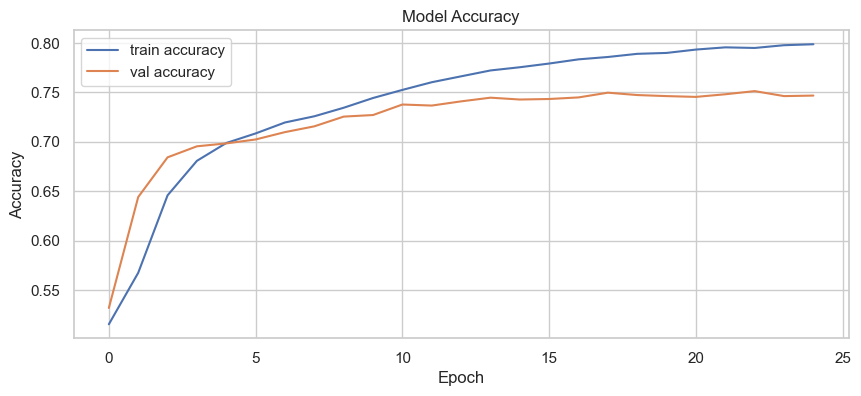

In [16]:
# Visualization model accuracy (train and val accuracy)

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history['accuracy'], label = 'train accuracy')
ax.plot(model_prediction.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

294/294 [==============================] - 3s 9ms/step
Model Accuracy on Test Data: 0.7318370386129135


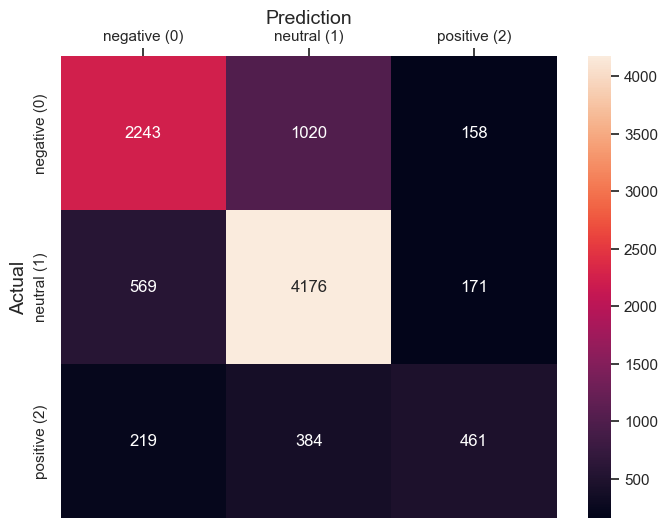

In [17]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()

In [ ]:
# Results from prediction sentiment on data test
text_clean = tweets['Clean_Text']
text_train, text_test = train_test_split(text_clean, test_size = 0.2, random_state = 0)
result_test = pd.DataFrame(data = zip(text_test, y_pred), columns = ['text', 'polarity'])
polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)
pd.set_option('max_colwidth', 300)
result_test

In [ ]:
# Initializing and preprocessing new text data
otherData = pd.DataFrame()
otherData['text'] = ['metaverse teknologi yang sangat menjanjikan',
                     'Tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif, ga paham materi blasss, kopong, berasa yauda kek ga kuliah' 
                    ]

otherData['text_clean'] = otherData['text'].apply(cleaningText)
otherData['text_clean'] = otherData['text_clean'].apply(casefoldingText)
otherData.drop(['text'], axis = 1, inplace = True)

otherData['text_preprocessed'] = otherData['text_clean'].apply(tokenizingText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(filteringText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(stemmingText)
otherData

In [ ]:
# Preprocessing text data

# Make text preprocessed (tokenized) to untokenized with toSentence Function
X_otherData = otherData['text_preprocessed'].apply(toSentence)
X_otherData = tokenizer.texts_to_sequences(X_otherData.values)
X_otherData = pad_sequences(X_otherData, maxlen = X.shape[1])
X_otherData

In [ ]:
# Results from prediction sentiment on text data

y_pred_otherData = model.predict(X_otherData)
otherData['Result Prediction'] = y_pred_otherData

polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
otherData['Result Prediction'] = otherData['Result Prediction'].map(polarity_decode)
otherData